In [2]:
#Package Loading
import numpy as np
import pandas as pd
import pycaret

import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from datetime import datetime

import matplotlib.pyplot as plt

In [3]:
ys_data = pd.read_csv("./data/processed_final_dt_240103.csv")

In [4]:
random_seed = 94

In [11]:
data=ys_data.sample(frac=1, random_state=random_seed)
data.iloc[:,5:].reset_index(drop=True)

hjorth_activity_II  hjorth_activity_Pleth  hjorth_activity_Resp  \
0               1.598486               0.522680              0.458383   
1               2.505961               0.526072              0.342287   
2               1.775863               0.391646              0.486023   
3               3.888858               0.461593              0.227573   
4              12.681334               0.489934              0.334079   
...                  ...                    ...                   ...   
5474            4.569297               0.403453              0.341814   
5475            3.563382               0.317419              0.314679   
5476            1.631982               0.367634              0.443346   
5477            2.384286               0.763347              0.449389   
5478            2.191384               0.469668              0.570652   

      hjorth_complexity_II  hjorth_morbidity_II  kurtosis_II  kurtosis_Pleth  \
0                 1.781410             0.467424     8.388847       -0.040174   
1                 2.576816             0.304723    24.168604       -0.710762   
2                 2.401229             0.476919    20.263418       -0.956968   
3                 2.178686             0.287936    17.168861       -0.570275   
4                 2.705861             0.236592    15.102069       -0.510232   
...                    ...                  ...          ...             ...   
5474              2.179011             0.243552    18.466172       -0.959071   
5475              2.148627             0.344059    24.799863       -1.274870   
5476              1.711809             0.408820    14.956911       -1.013246   
5477              2.300970             0.331741    17.279811        0.209503   
5478              2.443544             0.286950    15.348274       -0.689211   

      kurtosis_Resp  skewness_II  skewness_Pleth  skewness_Resp  HRs_median  \
0         -0.801156     1.870807        0.168530       0.309317    123.6600   
1         -1.142189     4.125665        0.719899       0.391052     57.2100   
2         -0.576440     3.722504        0.345336       0.527339     52.7950   
3         -1.540334     3.930401        0.589493       0.102579     86.3850   
4         -1.247374     3.882227       -0.124922       0.461840     88.7450   
...             ...          ...             ...            ...         ...   
5474      -1.136014     3.879958        0.628338       0.106772     52.5000   
5475      -1.254580     4.557476        0.378749       0.049971     80.1600   
5476      -0.793609     1.194737        0.568038       0.492861     57.0000   
5477      -0.768907     3.754813        1.076446       0.250102     78.4300   
5478      -0.618103     3.500225        0.472042       0.922968     72.0075   

      RRs_median  SpO2s_median    HRs_std   RRs_std  SpO2s_std  
0          21.50       100.000   1.397630  3.875521   0.054340  
1          14.50       100.000   2.001774  1.193959   0.000000  
2          13.00       100.000   9.261152  1.219093   0.077198  
3          28.00        99.650   4.197462  2.715875   0.255440  
4          16.75        99.000  14.294917  2.180434   1.251747  
...          ...           ...        ...       ...        ...  
5474       11.50        99.950   1.625456  2.358809   0.217077  
5475       21.00       100.000   1.283188  1.898615   0.000000  
5476       14.50        99.900   5.090297  2.436323   0.251797  
5477       16.50        98.175   2.241817  2.271367   0.441621  
5478       10.00        99.850   2.313491  1.057293   0.176494  

[5479 rows x 17 columns]

In [12]:
data = data.query("hjorth_activity_Pleth < 1000")

In [6]:
#환자별로 train, test 데이터셋을 구분하기 위해 환자 아이디를 추출
uni_pids=pd.unique(data["pid"])
tr_uni_pids=uni_pids[:int((len(uni_pids)*0.8))] #80% 환자의 데이터는 학습용으로 활용
te_uni_pids=uni_pids[int((len(uni_pids)*0.8)):] #20% 환자의 데이터는 테스트용으로 활용

In [7]:
data['tr_yn']=0
data.loc[data.pid.isin(tr_uni_pids),'tr_yn']=1 #훈련에 사용될 데이터만 1로 표시

In [8]:
#Train, test 데이터 분리
train_data=data[data["tr_yn"]==1].iloc[:,:-1]
test_data=data[data["tr_yn"]==0].iloc[:,:-1]

In [9]:
#train_data를 환자 아이디로 정렬 -> CV 과정에서 한 환자의 데이터가 여러 fold에 들어가지 않도록 
train_data=train_data.sort_values(by=['pid'])

In [14]:
train_data.cam.value_counts()

1    3005
0    2125
Name: cam, dtype: int64

In [15]:
test_data.cam.value_counts()

0    254
1     94
Name: cam, dtype: int64

In [16]:
fold_groups = train_data['pid']  # 환자 ID에 해당하는 열 이름으로 변경해야 합니다.

In [17]:
### 중요!! ###
#환자 아이디로 정렬된 train_data가 CV 과정에서 한 환자의 데이터가 여러 fold에 들어가지 않도록 data_split_shuffle=False로 설정
from pycaret.classification import * 
setup_clf = setup(data=train_data, target='cam', use_gpu=False, data_split_shuffle=True, memory=False,
                  fold_strategy='groupkfold', fold_groups=fold_groups, ignore_features = ['pid', 'cam_time'],
                  n_jobs=2,
                  session_id = 8709)

In [19]:
base_learner = create_model('rf')

In [20]:
final_model=tune_model(base_learner, n_iter=20, early_stopping=True, optimize='Precision')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [21]:
final_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=3, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=2, oob_score=False,
                       random_state=8709, verbose=0, warm_start=False)

##### prediction_on_train = predict_model(final_model, data=train_data)

In [22]:
from sklearn.metrics import roc_curve, auc
from numpy import argmax

In [23]:
model = final_model
model = finalize_model(model)
calibrated_model = calibrate_model(model, method='isotonic')

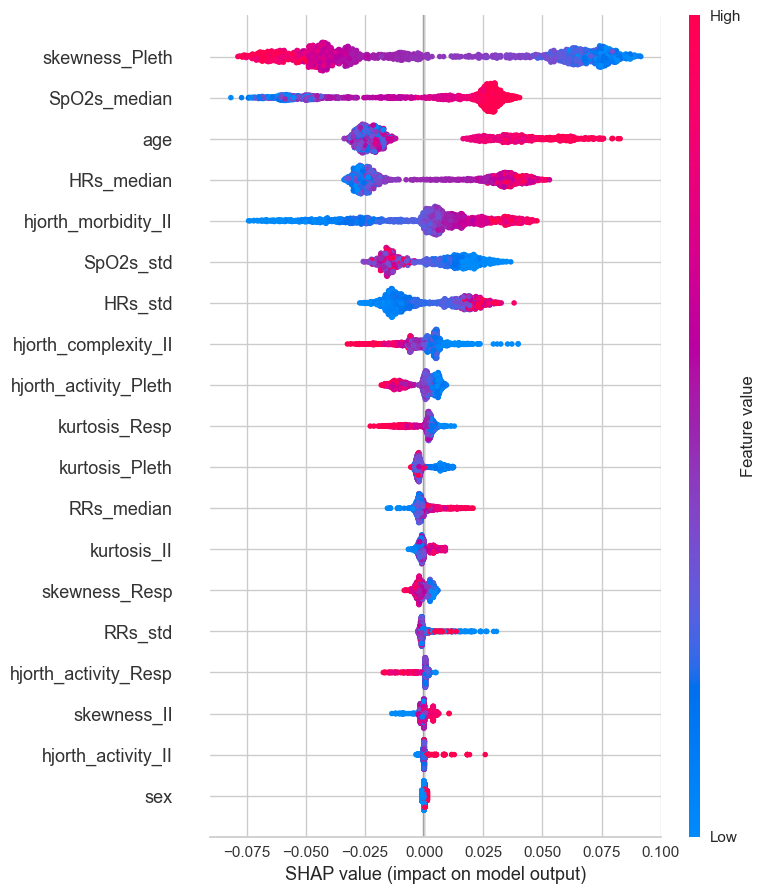

In [24]:
interpret_model(final_model, 'summary')

In [26]:
#Delirium negative로 예측한 경우일 수록 Score 값이 0에 가깝도록 해주기 위해 1-score 값으로 변경
#default는 예측한 각 class일 확률값을 갖고 있음. 즉 class 1로 예측한 경우는 class 1일 확율, class 0으로 예측한 경우는 class 0일 확률
prediction_on_train.loc[prediction_on_train["prediction_label"]==0,'prediction_score']=1-prediction_on_train[prediction_on_train["prediction_label"]==0]["prediction_score"]
prediction.loc[prediction["prediction_label"]==0,'prediction_score']=1-prediction[prediction["prediction_label"]==0]["prediction_score"]

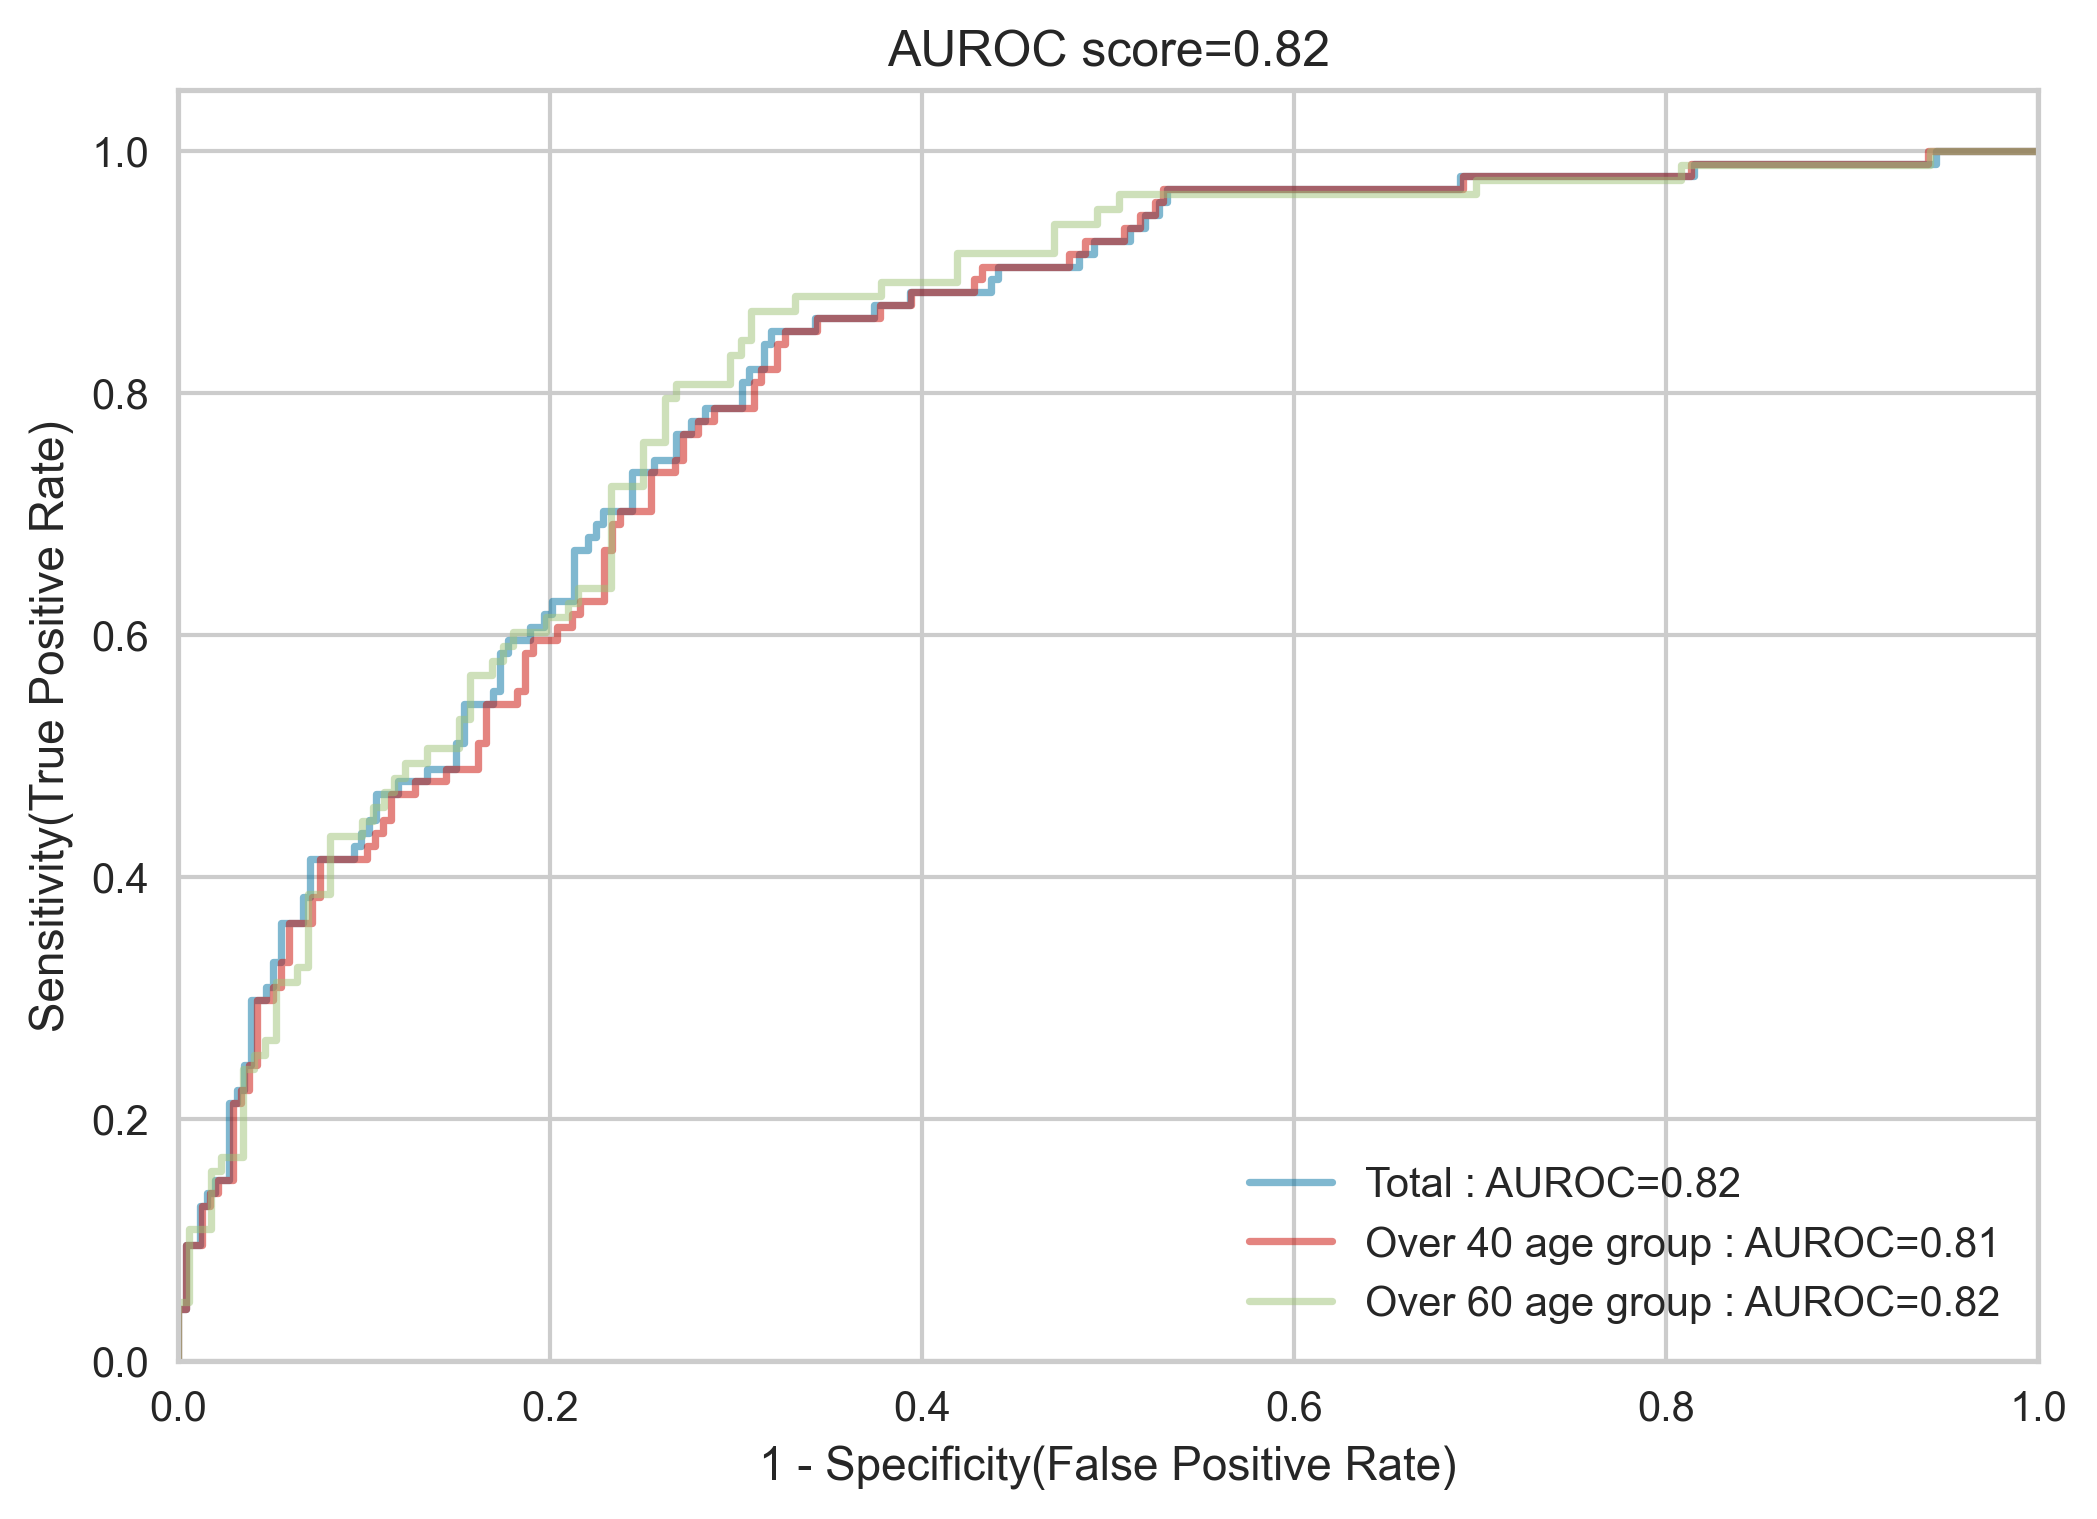

In [31]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve, roc_auc_score

roc_score = roc_auc_score(prediction['cam'], prediction['prediction_score'])
fpr, tpr, _ = roc_curve(prediction['cam'], prediction['prediction_score'])

fpr40, tpr40, _ = roc_curve(prediction.query("age >= 40")['cam'], prediction.query("age >= 40")['prediction_score'])
roc_score40 = roc_auc_score(prediction.query("age >= 40")['cam'], prediction.query("age >= 40")['prediction_score'])

fpr60, tpr60, _ = roc_curve(prediction.query("age >= 60")['cam'], prediction.query("age >= 60")['prediction_score'])
roc_score60 = roc_auc_score(prediction.query("age >= 60")['cam'], prediction.query("age >= 60")['prediction_score'])

plt.step(fpr, tpr, color='b', alpha=0.5, label='Total : AUROC={0:0.2f}'.format(roc_score),
         where='post')

plt.step(fpr40, tpr40, color='r', alpha=0.5, label='Over 40 age group : AUROC={0:0.2f}'.format(roc_score40),
         where='post')

plt.step(fpr60, tpr60, color='g', alpha=0.5, label='Over 60 age group : AUROC={0:0.2f}'.format(roc_score60),
         where='post')

plt.legend()
# plt.fill_between(fpr, tpr, step='post', alpha=0.2,
#                  color='b')

plt.xlabel('1 - Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('AUROC score={0:0.2f}'.format(
          roc_score))
plt.gcf().set_dpi(300)



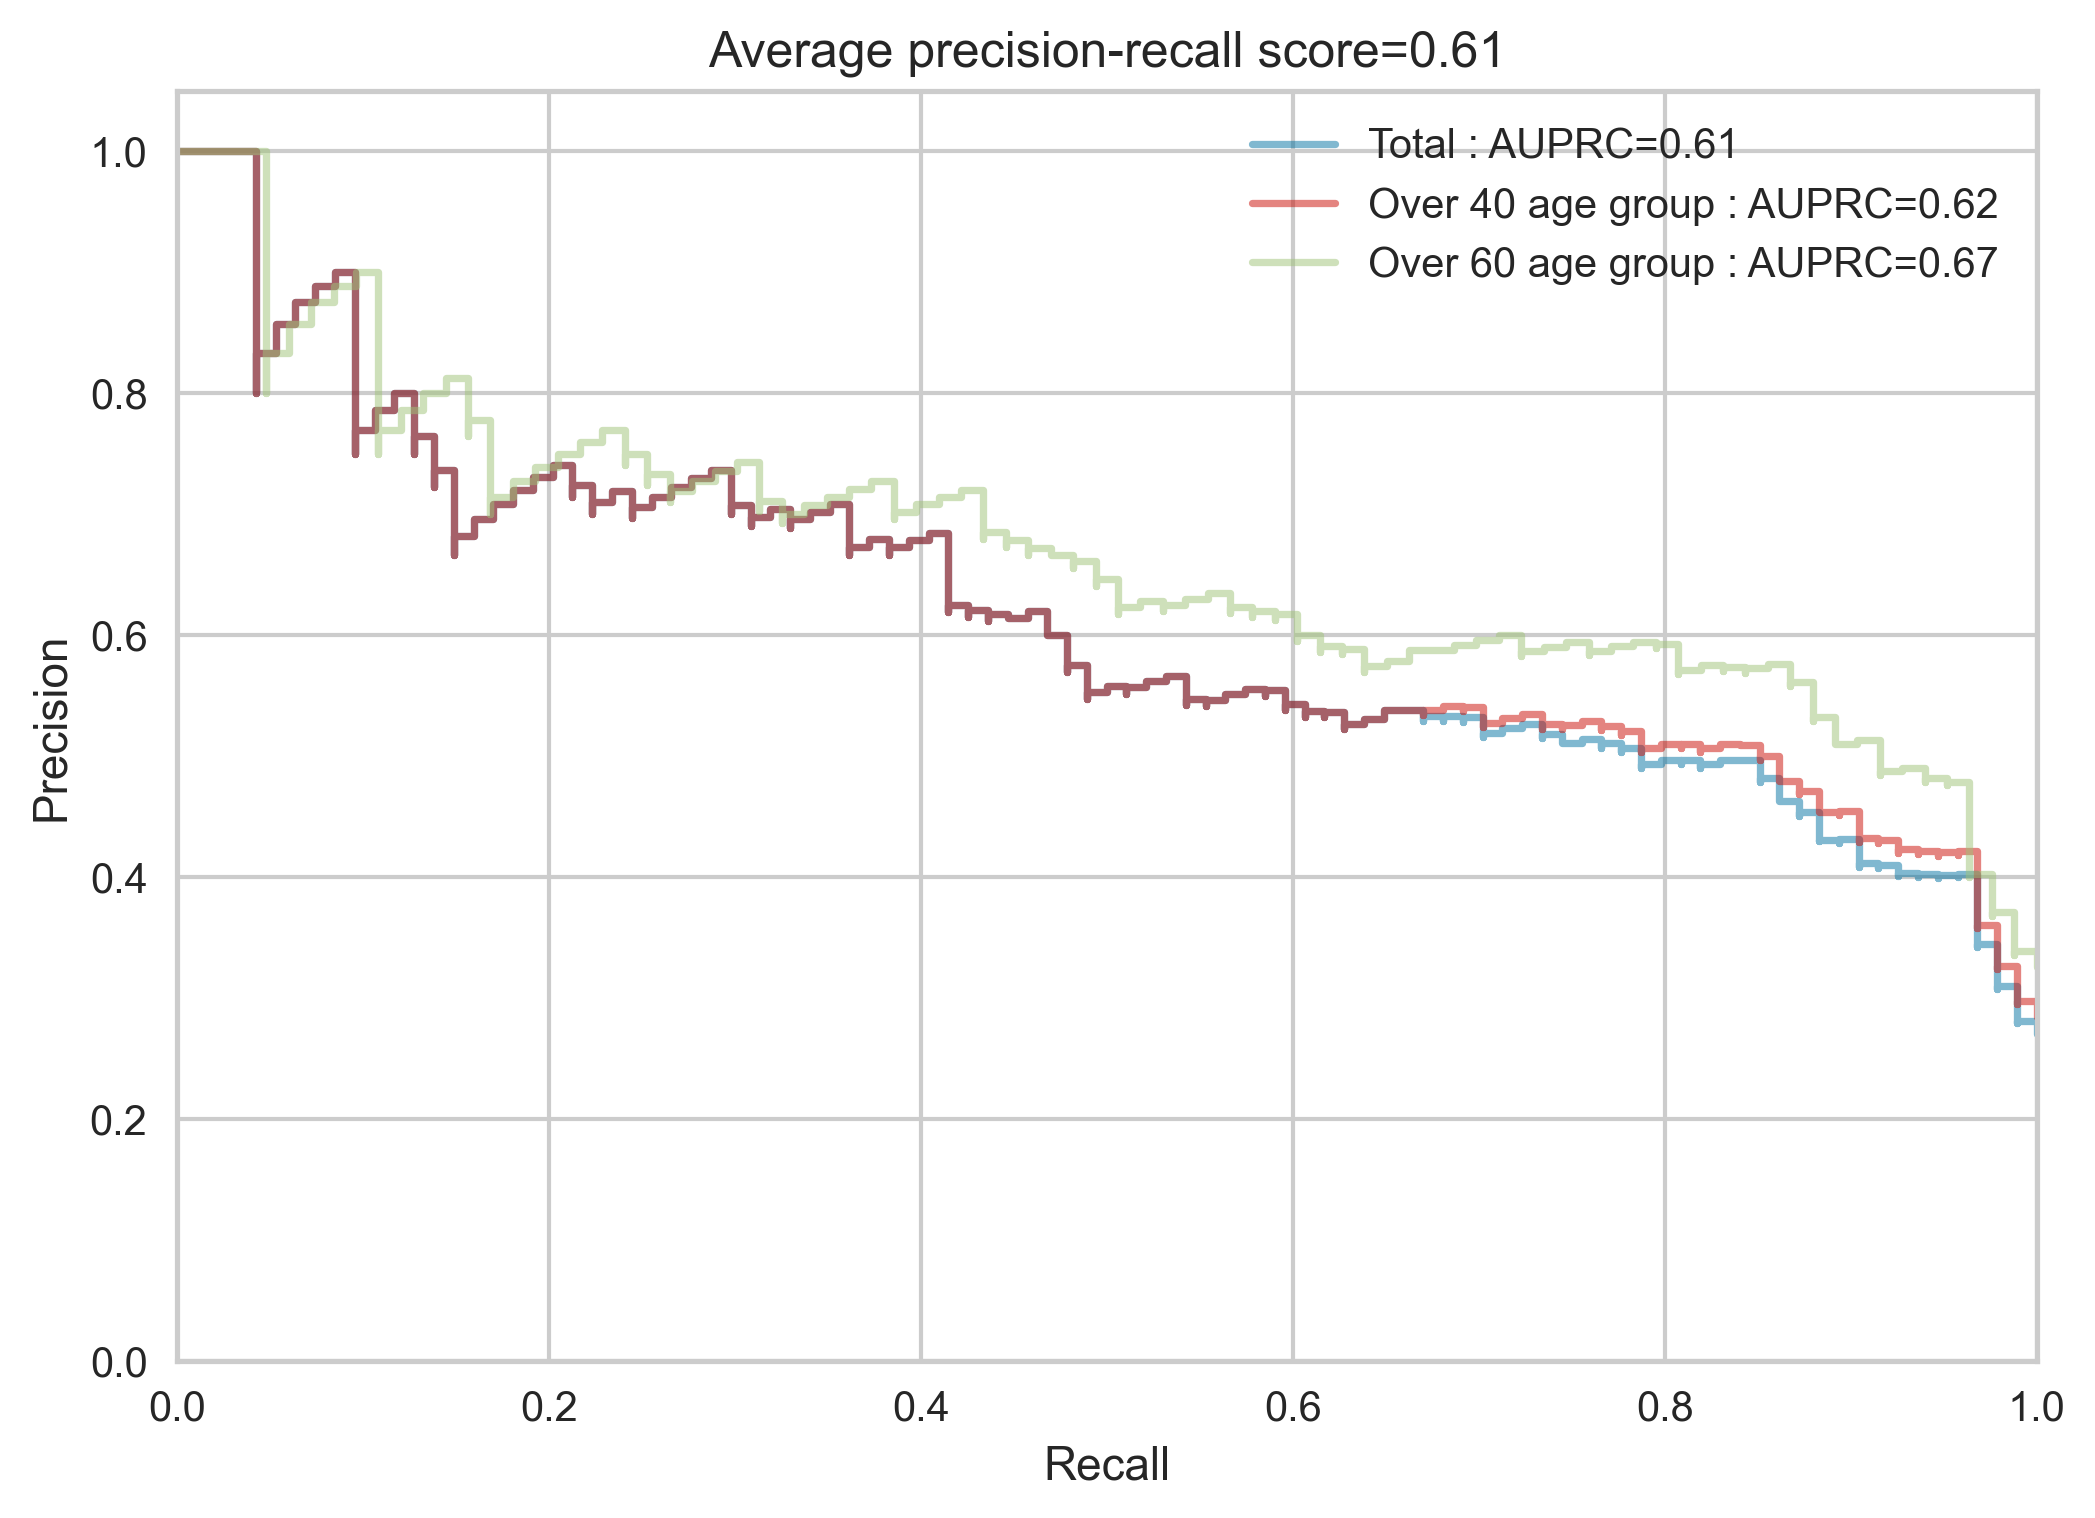

In [32]:
average_precision = average_precision_score(prediction['cam'], prediction['prediction_score'])
average_precision40 = average_precision_score(prediction.query("age >= 40")['cam'], prediction.query("age >= 40")['prediction_score'])
average_precision60 = average_precision_score(prediction.query("age >= 60")['cam'], prediction.query("age >= 60")['prediction_score'])

#print('Average precision-recall score : {}'.format(average_precision))

precision, recall, _ = precision_recall_curve(prediction['cam'], prediction['prediction_score'])
precision40, recall40, _ = precision_recall_curve(prediction.query("age >= 40")['cam'], prediction.query("age >= 40")['prediction_score'])
precision60, recall60, _ = precision_recall_curve(prediction.query("age >= 60")['cam'], prediction.query("age >= 60")['prediction_score'])
plt.step(recall, precision, color='b', alpha=0.5, label='Total : AUPRC={0:0.2f}'.format(average_precision),
         where='post')
plt.step(recall40, precision40, color='r', alpha=0.5, label='Over 40 age group : AUPRC={0:0.2f}'.format(average_precision40),
         where='post')
plt.step(recall60, precision60, color='g', alpha=0.5, label='Over 60 age group : AUPRC={0:0.2f}'.format(average_precision60),
         where='post')
plt.legend()
# plt.fill_between(recall, precision, step='post', alpha=0.2,
#                  color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision-recall score={0:0.2f}'.format(
          average_precision))
plt.gcf().set_dpi(300)

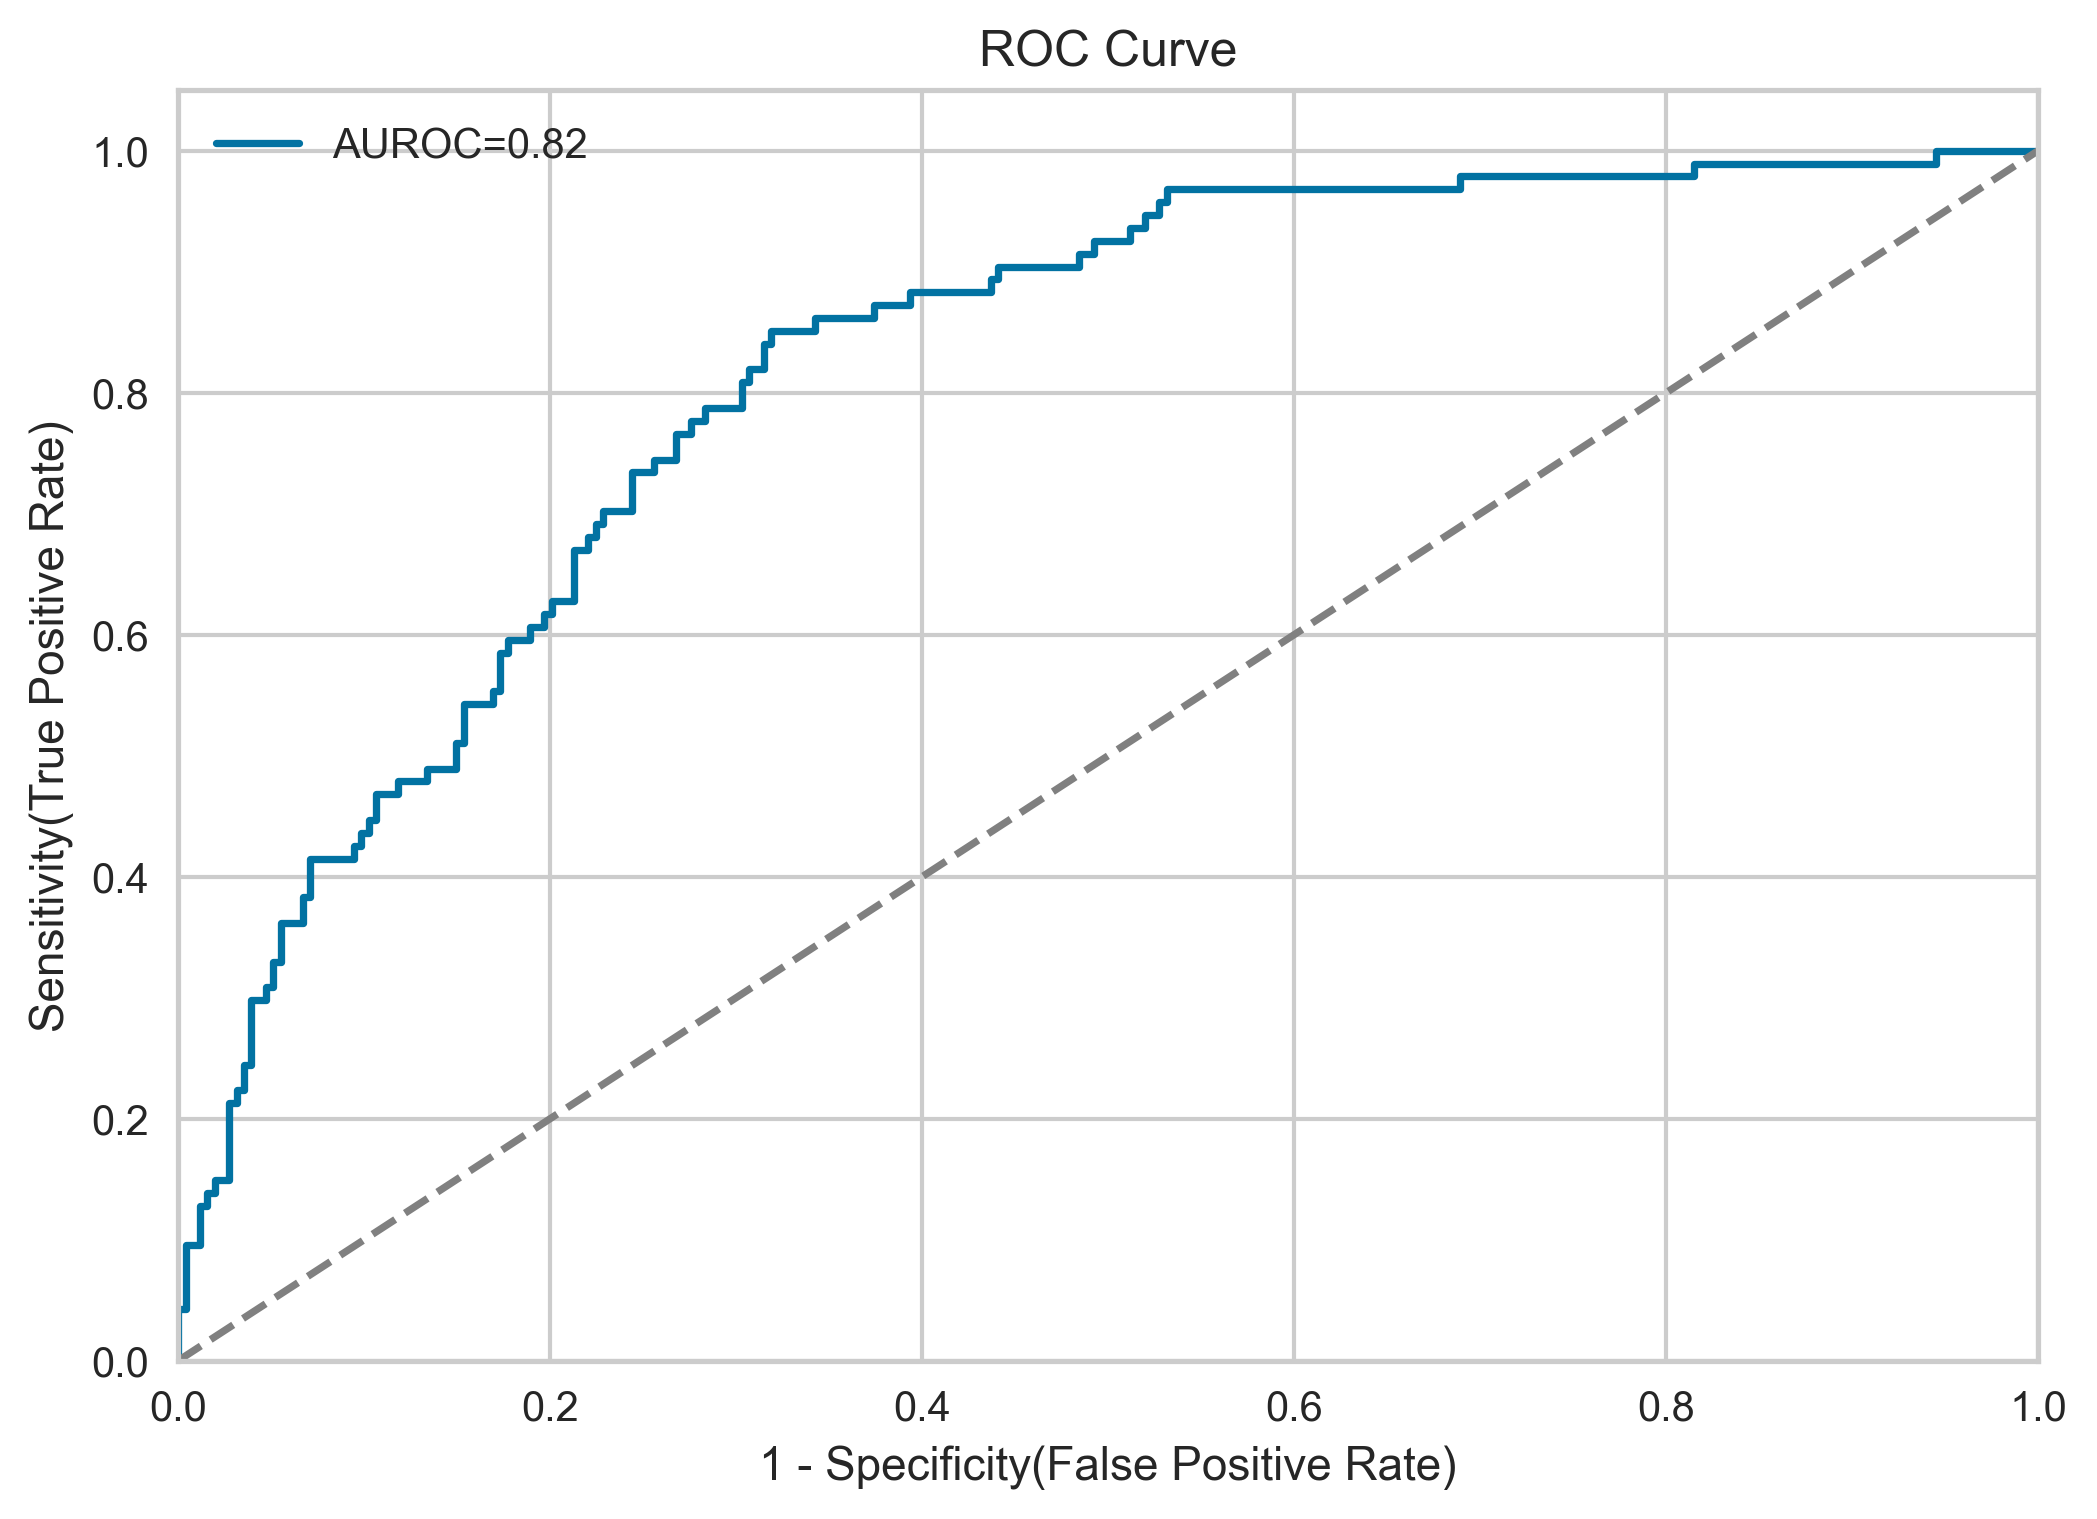

In [33]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Assuming prediction['cam'] and prediction['prediction_score'] are defined
# along with roc_score
fpr, tpr, _ = roc_curve(prediction['cam'], prediction['prediction_score'])

plt.step(fpr, tpr, color='b', alpha=1, where='post', label='AUROC={0:0.2f}'.format(roc_score))

# Add a dashed diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('1 - Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC Curve')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()


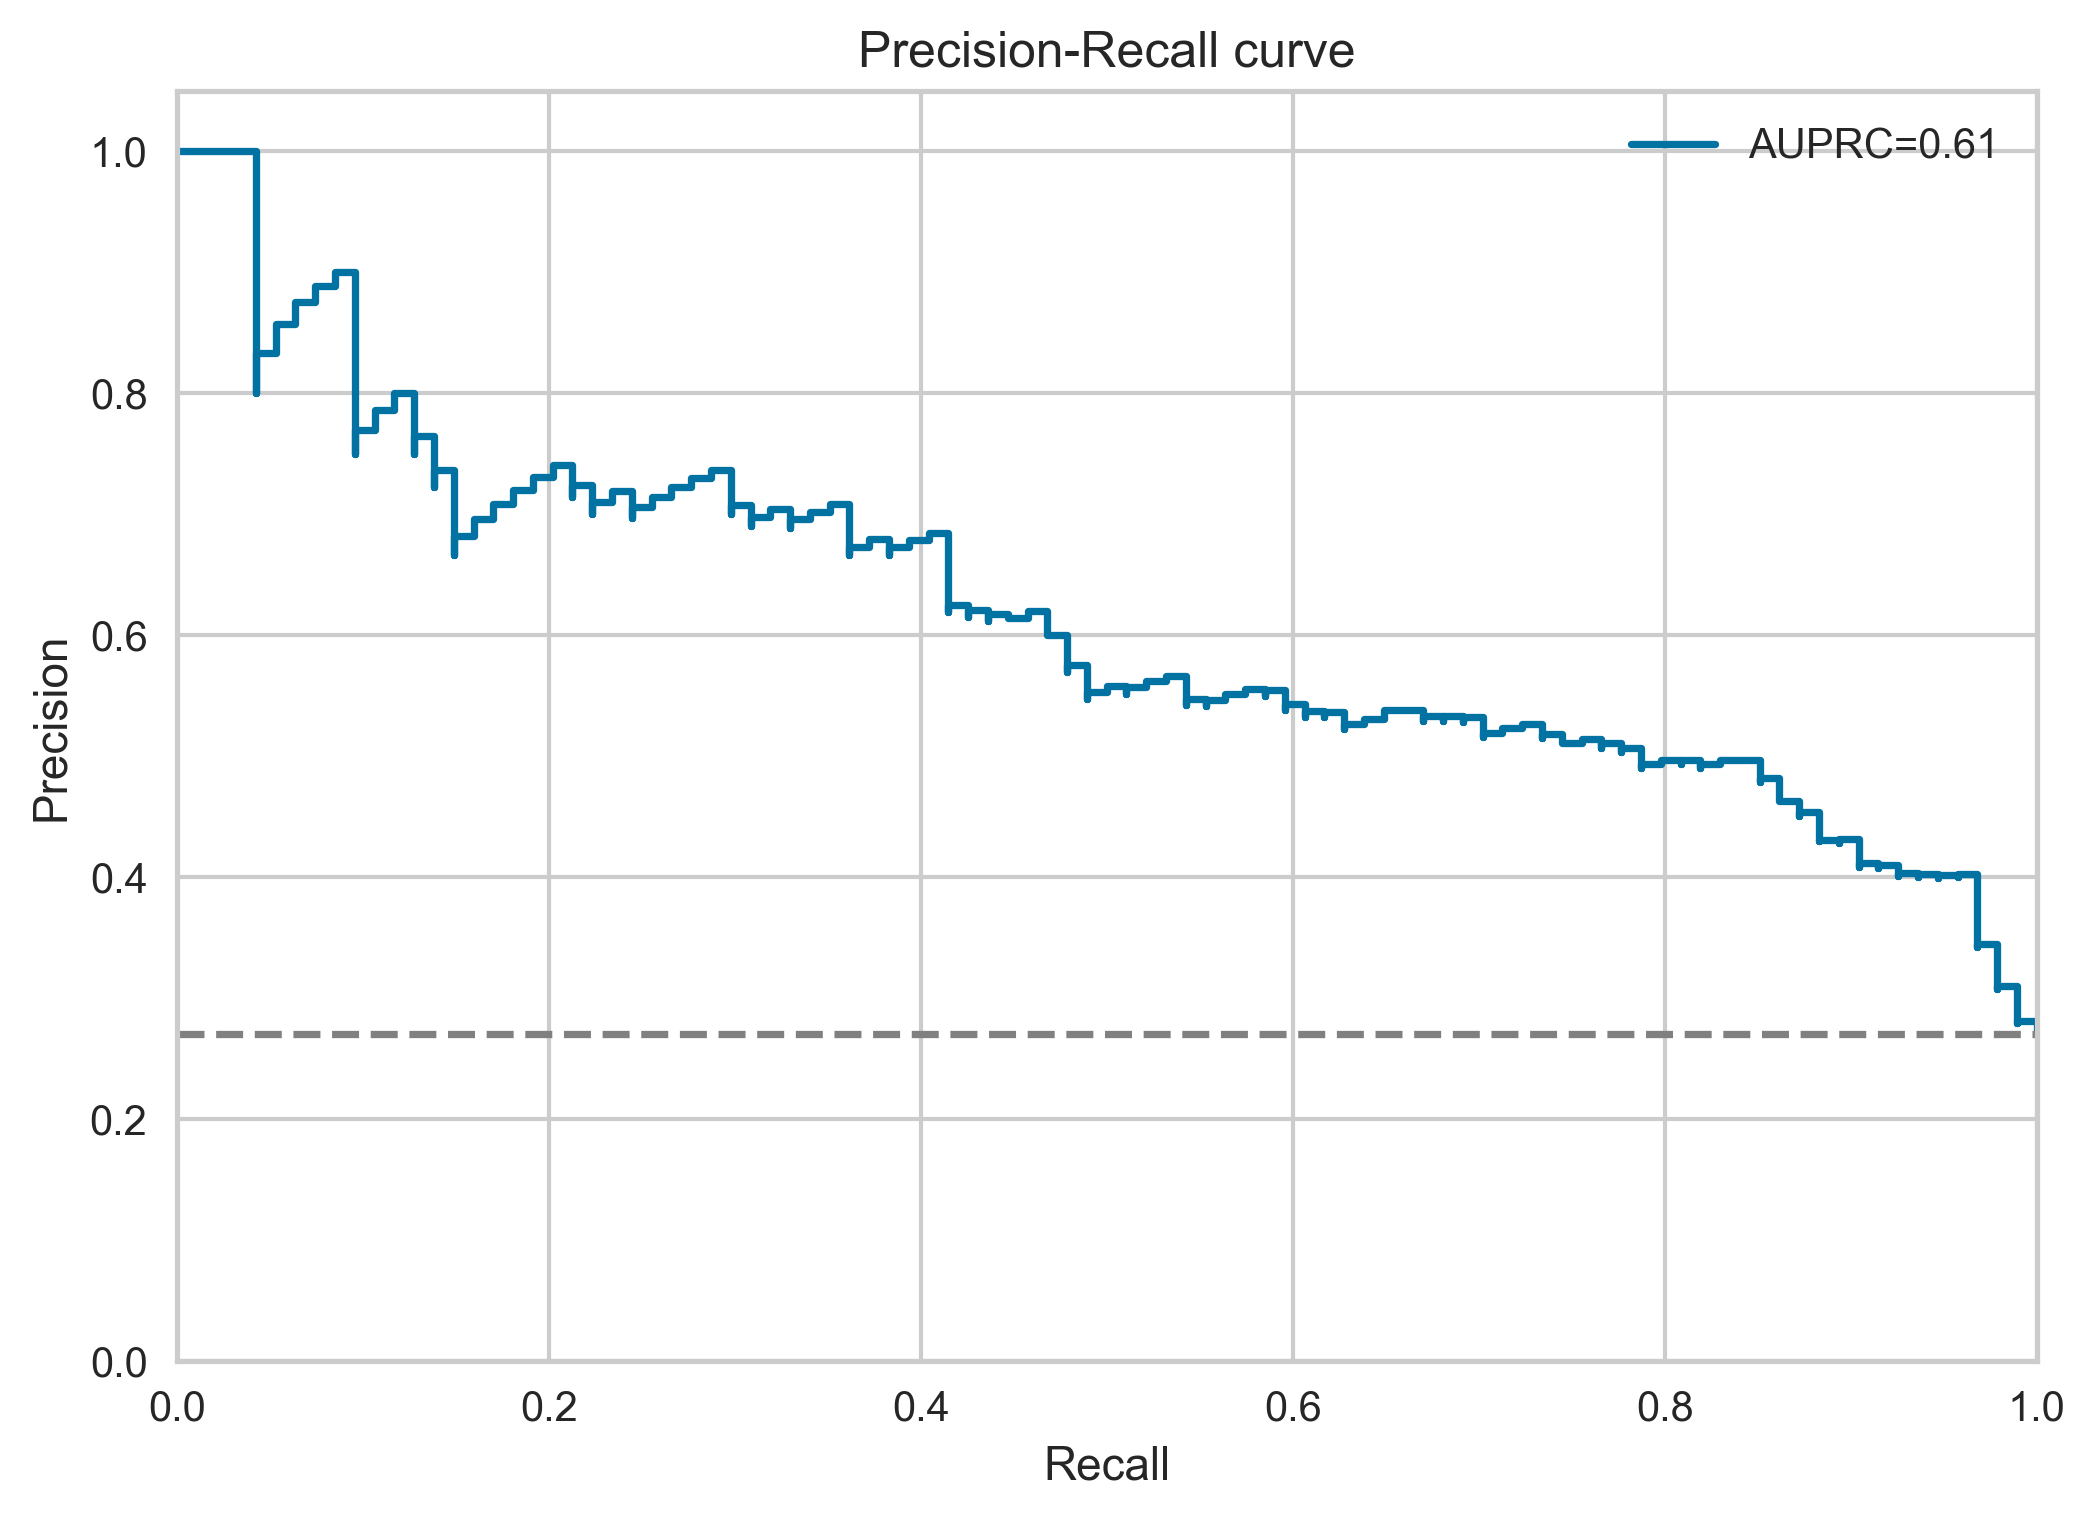

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(prediction['cam'], prediction['prediction_score'])

plt.step(recall, precision, color='b', alpha=1, where='post', label='AUPRC={0:0.2f}'.format(average_precision))

# Calculate the no-skill line as the ratio of positive instances
no_skill = sum(prediction['cam']) / len(prediction['cam'])
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()


# Temporal validation ROC, PRC

In [14]:
temporal = pd.read_csv("./(temporal)final_feature.csv")

In [16]:
temporal.iloc[:,11:]

HR_median     HR_std  RESP_median  RESP_std  SpO2_median  SpO2_std  \
0         55.00   3.511885         17.0  2.078805         99.7  0.180278   
1         54.00   4.513715         14.0  1.616888         99.9  0.376488   
2         92.00   3.647182         14.0  2.688986         97.5  0.596794   
3         82.00   6.077474         11.0  1.422047        100.0  0.204835   
4         83.00  10.055738         15.0  3.942075        100.0  0.006455   
...         ...        ...          ...       ...          ...       ...   
4484      70.00   3.360872         14.5  2.125178         93.6  4.021904   
4485      68.75   4.632107         13.0  3.156229         95.8  3.514747   
4486      74.00   2.828427         17.0  7.071068         98.1  0.493288   
4487      64.00   2.426010         12.0  1.337887         97.2  0.490484   
4488      65.00   3.475747         14.0  2.149808         96.9  0.747874   

      ECGII_hjorth_activity  ECGII_hjorth_morbidity  ECGII_hjorth_complexity  \
0                  6.685141                0.313524                 4.795091   
1                  3.382431                0.287380                 5.071465   
2                  0.553305                0.307594                 4.575839   
3                  0.723584                0.323635                 4.537616   
4                  0.760484                0.313815                 4.610978   
...                     ...                     ...                      ...   
4484               0.908126                0.309914                 4.760848   
4485               0.867781                0.370506                 4.181830   
4486               1.335904                0.311110                 4.653370   
4487               1.317887                0.311125                 4.858259   
4488               1.434608                0.319670                 4.694229   

      ECGII_kurtosis  ...  pleth_hjorth_activity  pleth_hjorth_morbidity  \
0          26.604234  ...               0.609179                0.588782   
1          17.596903  ...               0.680147                0.793707   
2           0.695815  ...               0.369576                0.696093   
3           2.030092  ...               0.411180                0.738001   
4           1.550377  ...               0.465603                0.757027   
...              ...  ...                    ...                     ...   
4484        6.040781  ...               0.449190                0.617065   
4485        3.846438  ...               0.484589                0.829649   
4486        8.365174  ...               0.351804                0.542581   
4487       10.767666  ...               0.465174                0.956576   
4488       13.001228  ...               0.495619                0.848843   

      pleth_hjorth_complexity  pleth_kurtosis  pleth_skewness  \
0                    2.754749        0.138733        0.654975   
1                    2.043976        0.606497        1.081898   
2                    2.328416       -0.869141        0.241565   
3                    2.197962       -0.702502        0.340180   
4                    2.141070       -0.661317        0.284245   
...                       ...             ...             ...   
4484                 2.629235       -0.629128        0.396913   
4485                 1.955016       -0.133062        0.195407   
4486                 2.983473       -1.080713        0.317030   
4487                 1.694424       -0.329339        0.363314   
4488                 1.911120       -0.279223        0.434107   

      RESP_hjorth_activity  RESP_hjorth_morbidity  RESP_hjorth_complexity  \
0                 0.326992               0.554816                1.980757   
1                 0.467397               0.643087                1.710043   
2                 0.860314               0.547709                1.995260   
3                 0.603845               0.639907                1.720886   
4                 0.642212               0.648150    

In [39]:
temporal = temporal.query("age > 18")

In [40]:
temporal.columns

Index(['NO', 'patient_id', 'camicu_time', 'cam_icu', 'wave_start', 'wave_end',
       'vital_start', 'vital_end', 'birth_date', 'sex', 'age', 'HR_median',
       'HR_std', 'RESP_median', 'RESP_std', 'SpO2_median', 'SpO2_std',
       'ECGII_hjorth_activity', 'ECGII_hjorth_morbidity',
       'ECGII_hjorth_complexity', 'ECGII_kurtosis', 'ECGII_skewness',
       'pleth_hjorth_activity', 'pleth_hjorth_morbidity',
       'pleth_hjorth_complexity', 'pleth_kurtosis', 'pleth_skewness',
       'RESP_hjorth_activity', 'RESP_hjorth_morbidity',
       'RESP_hjorth_complexity', 'RESP_kurtosis', 'RESP_skewness'],
      dtype='object')

In [42]:
tv = temporal[['patient_id', 'camicu_time', 'cam_icu', 
               'sex', 'age', 'HR_median', 
       'HR_std', 'RESP_median', 'RESP_std', 'SpO2_median', 'SpO2_std',
       'ECGII_hjorth_activity', 'ECGII_hjorth_morbidity',
       'ECGII_hjorth_complexity', 'ECGII_kurtosis', 'ECGII_skewness',
       'pleth_hjorth_activity',
       'pleth_kurtosis', 'pleth_skewness',
       'RESP_hjorth_activity', 'RESP_kurtosis', 'RESP_skewness']]

In [43]:
tv.columns = [
    'pid', 'cam_time', 'cam', 'sex', 'age', 'HRs_median', 'HRs_std', 'RRs_median', 'RRs_std',
    'SpO2s_median', 'SpO2s_std', 'hjorth_activity_II', 'hjorth_morbidity_II', 'hjorth_complexity_II',
    'kurtosis_II', 'skewness_II', 'hjorth_activity_Pleth', 'kurtosis_Pleth', 'skewness_Pleth',
    'hjorth_activity_Resp', 'kurtosis_Resp', 'skewness_Resp'
              
             ]

In [45]:
tv = tv.dropna(axis=0, how='any')

In [46]:
#문자형 데이터를 숫자형으로 변환
tv=tv.replace({'sex': 'M'}, {'sex': 0})
tv=tv.replace({'sex': 'F'}, {'sex': 1})

In [47]:
tv = tv.query("hjorth_activity_Pleth < 1000")

In [49]:
prediction_tv = predict_model(final_model, data=tv)

In [50]:
prediction_tv.loc[prediction_tv["prediction_label"]==0,'prediction_score']=1-prediction_tv[prediction_tv["prediction_label"]==0]["prediction_score"]

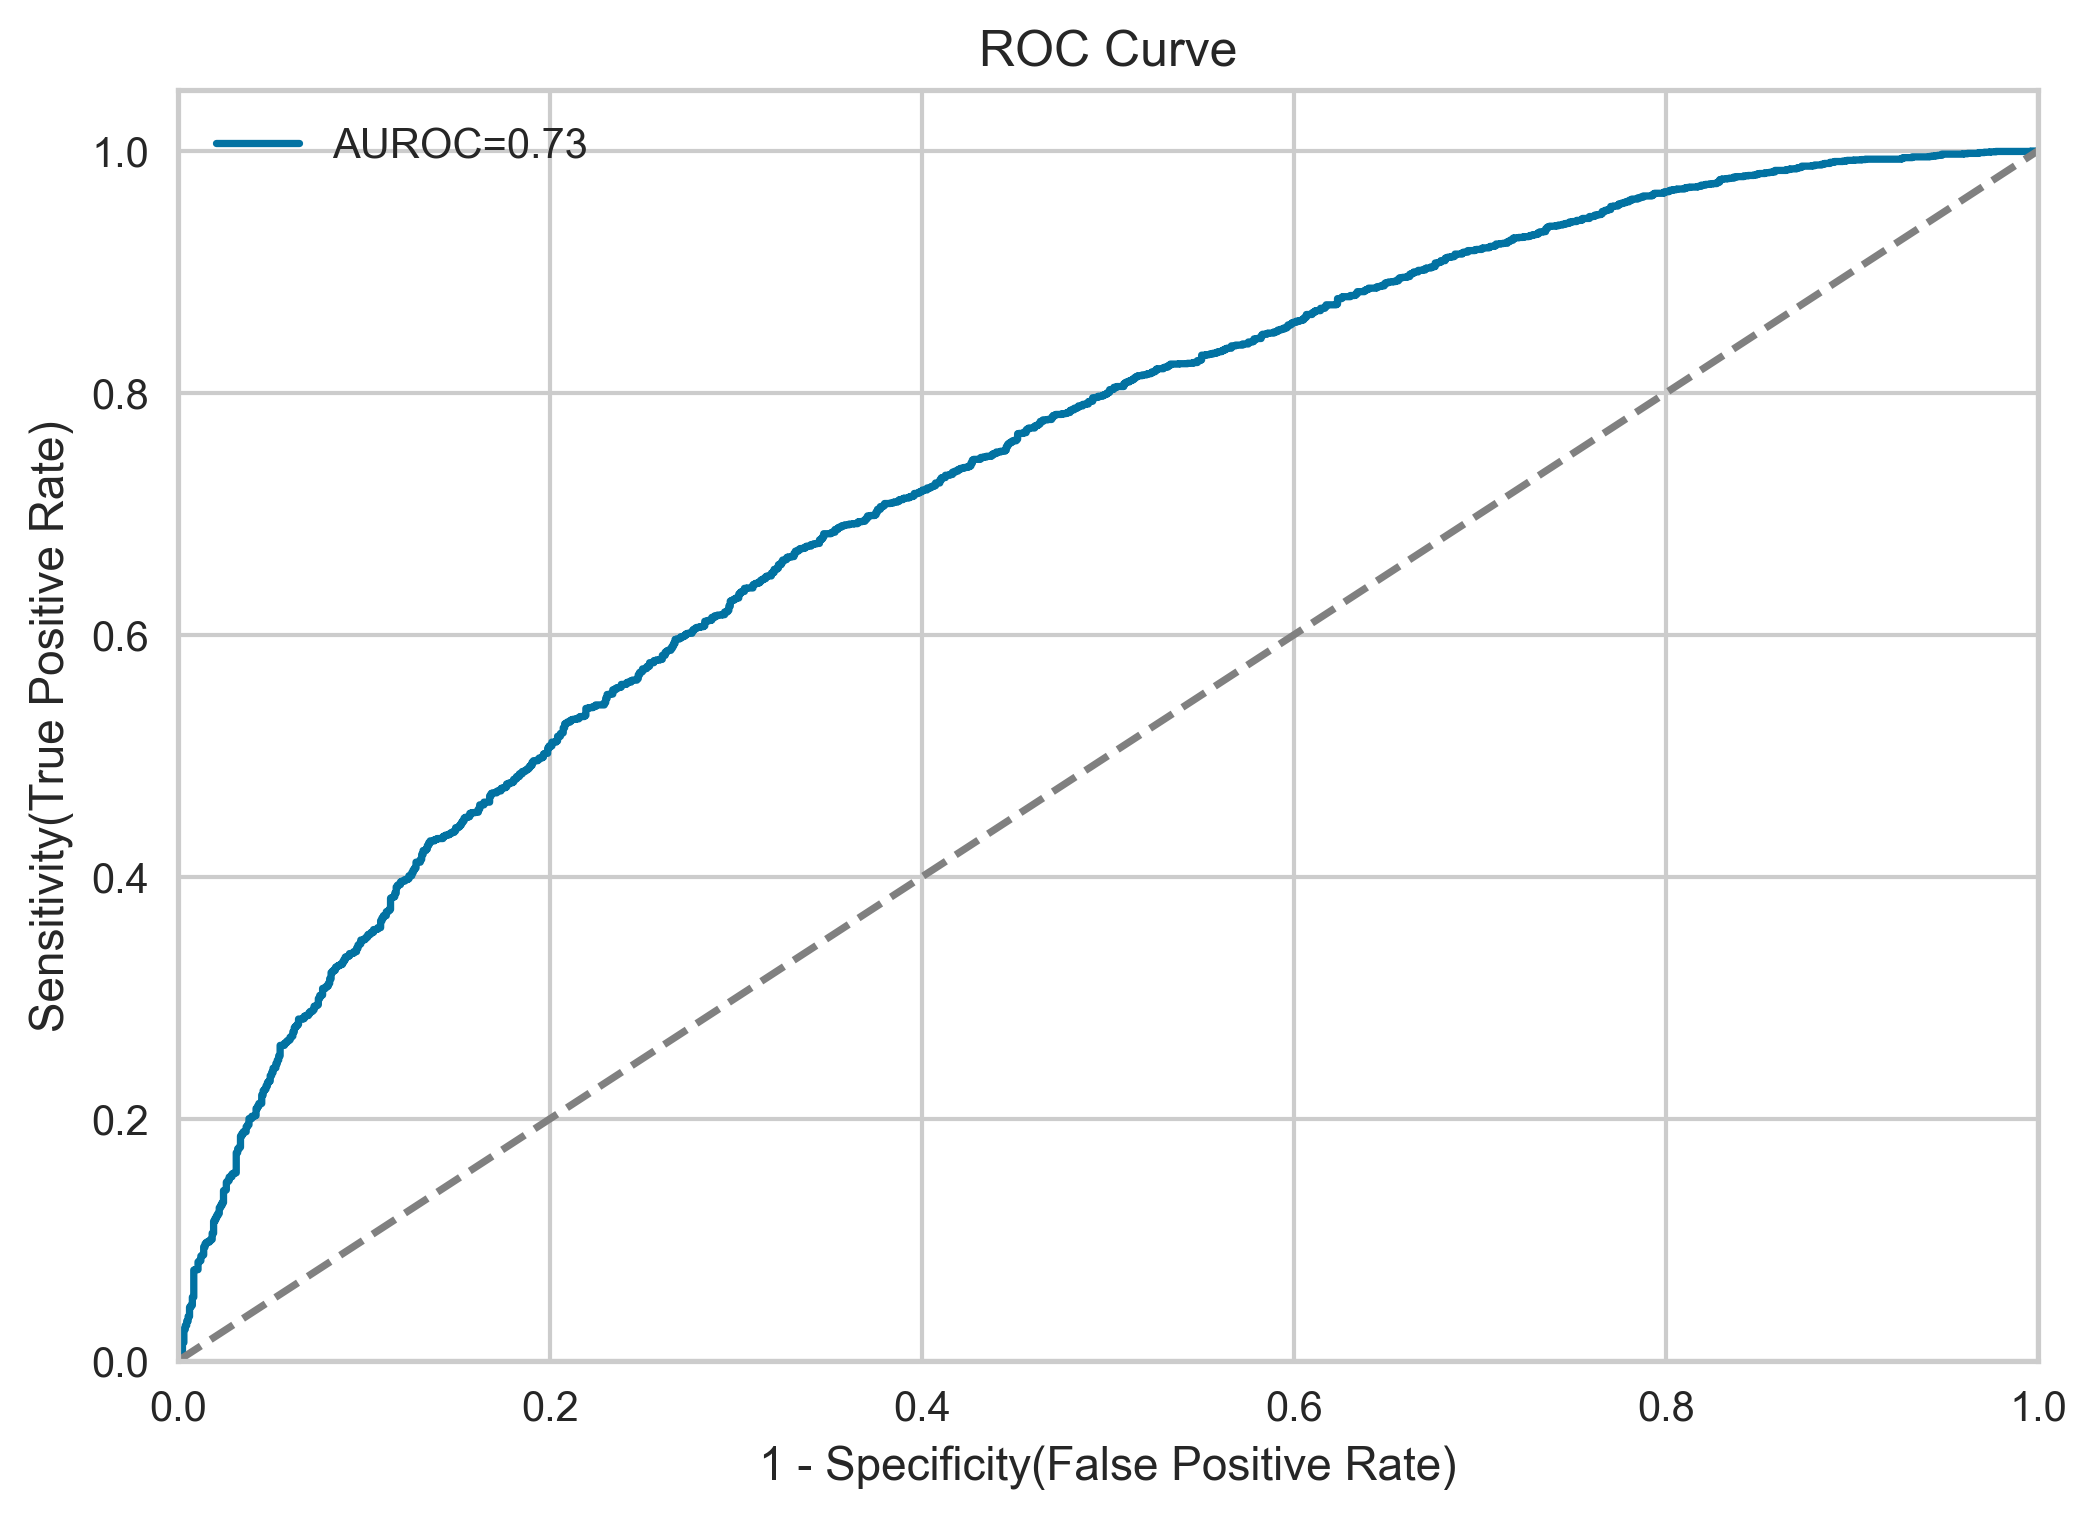

In [51]:
# Assuming prediction['cam'] and prediction['prediction_score'] are defined
# along with roc_score
roc_score = roc_auc_score(prediction_tv['cam'], prediction_tv['prediction_score'])
fpr, tpr, _ = roc_curve(prediction_tv['cam'], prediction_tv['prediction_score'])

plt.step(fpr, tpr, color='b', alpha=1, where='post', label='AUROC={0:0.2f}'.format(roc_score))

# Add a dashed diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('1 - Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC Curve')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()


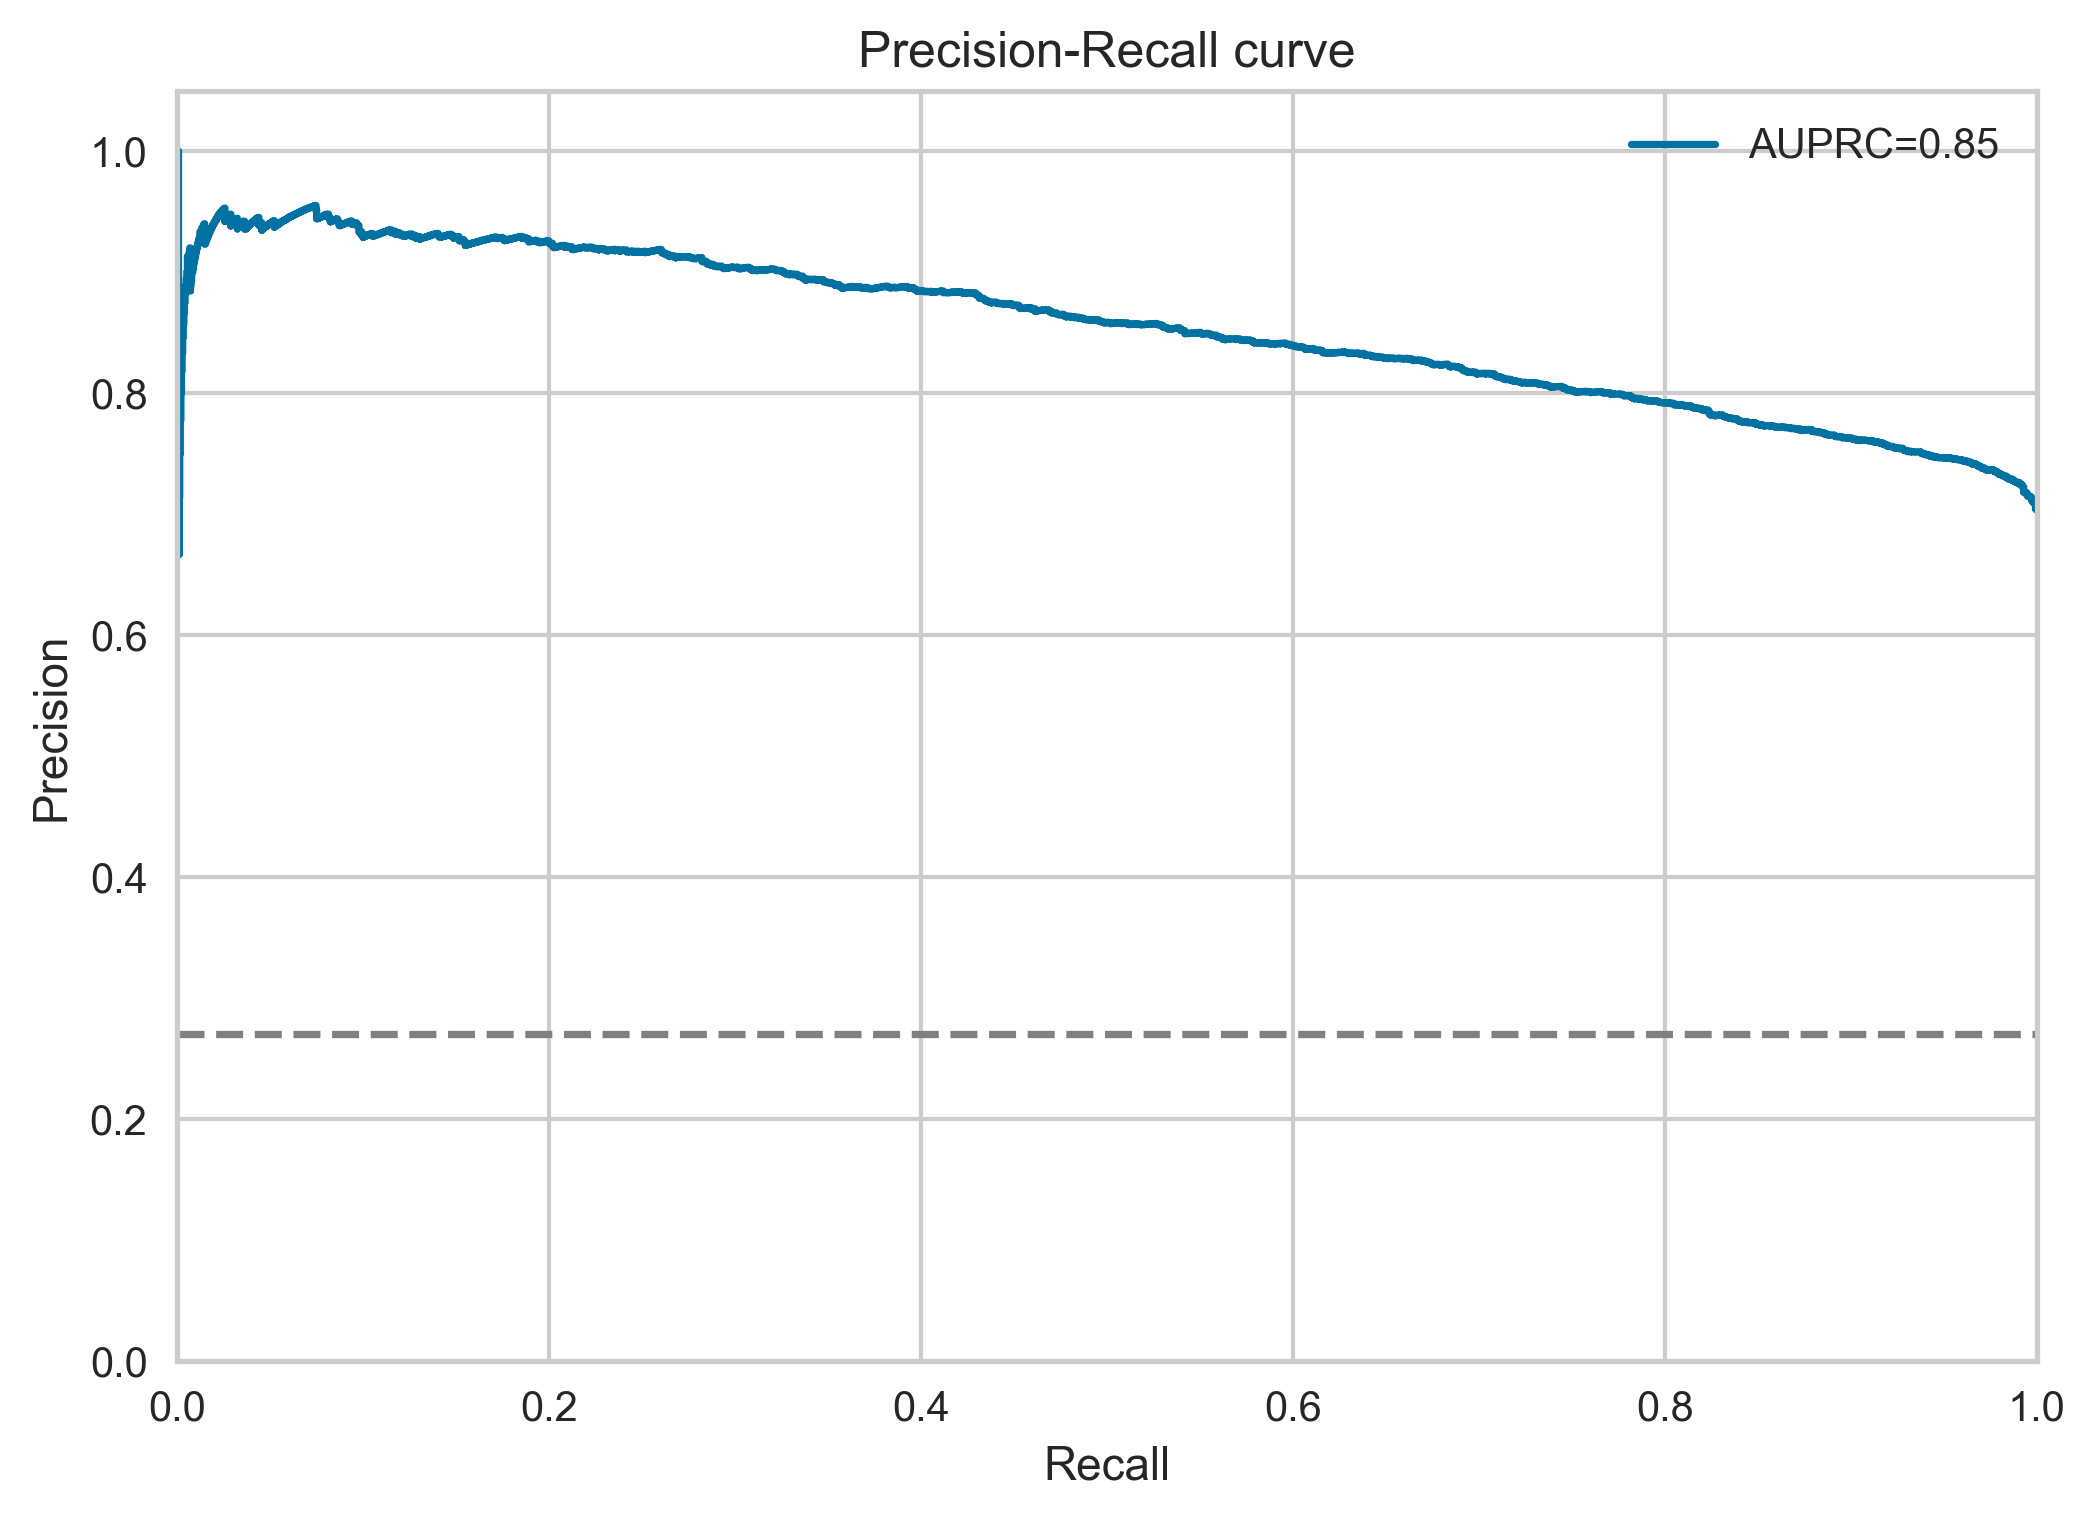

In [52]:
average_precision = average_precision_score(prediction_tv['cam'], prediction_tv['prediction_score'])
precision, recall, _ = precision_recall_curve(prediction_tv['cam'], prediction_tv['prediction_score'])

plt.step(recall, precision, color='b', alpha=1, where='post', label='AUPRC={0:0.2f}'.format(average_precision))

# Calculate the no-skill line as the ratio of positive instances
no_skill = sum(prediction['cam']) / len(prediction['cam'])
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()


In [53]:
tv.cam.value_counts()

1    3124
0    1314
Name: cam, dtype: int64

In [64]:
save_model(model, 'delirium_finalmodel')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/9c/cy0gwyx13172k5yh7sbsrw9r0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['sex', 'age', 'hjorth_activity_II',
                                              'hjorth_activity_Pleth',
                                              'hjorth_activity_Resp',
                                              'hjorth_complexity_II',
                                              'hjorth_morbidity_II',
                                              'kurtosis_II', 'kurtosis_Pleth',
                                              'kurtosis_Resp', 'skewness_II',
                                              's...
                  ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight='balanced',
                                       criterion='entropy', max_depth=10,
                                    

## DCA

In [53]:
import numpy as np

In [54]:
def net_benefit(y_true, y_prob, threshold):
    true_positives = (y_true & (y_prob > threshold)).sum()
    false_positives = ((y_true == 0) & (y_prob > threshold)).sum()
    benefit = true_positives - false_positives * (0.519 * (threshold / (1 - threshold)))
    return benefit / len(y_true)

In [55]:
thresholds_l = np.linspace(0,1,1000)

In [56]:
net_benefits = [net_benefit(prediction['cam'], prediction['prediction_score'], t) for t in thresholds_l]

In [57]:
treat_all = [prediction['cam'].sum() / len(prediction) - t for t in thresholds_l]

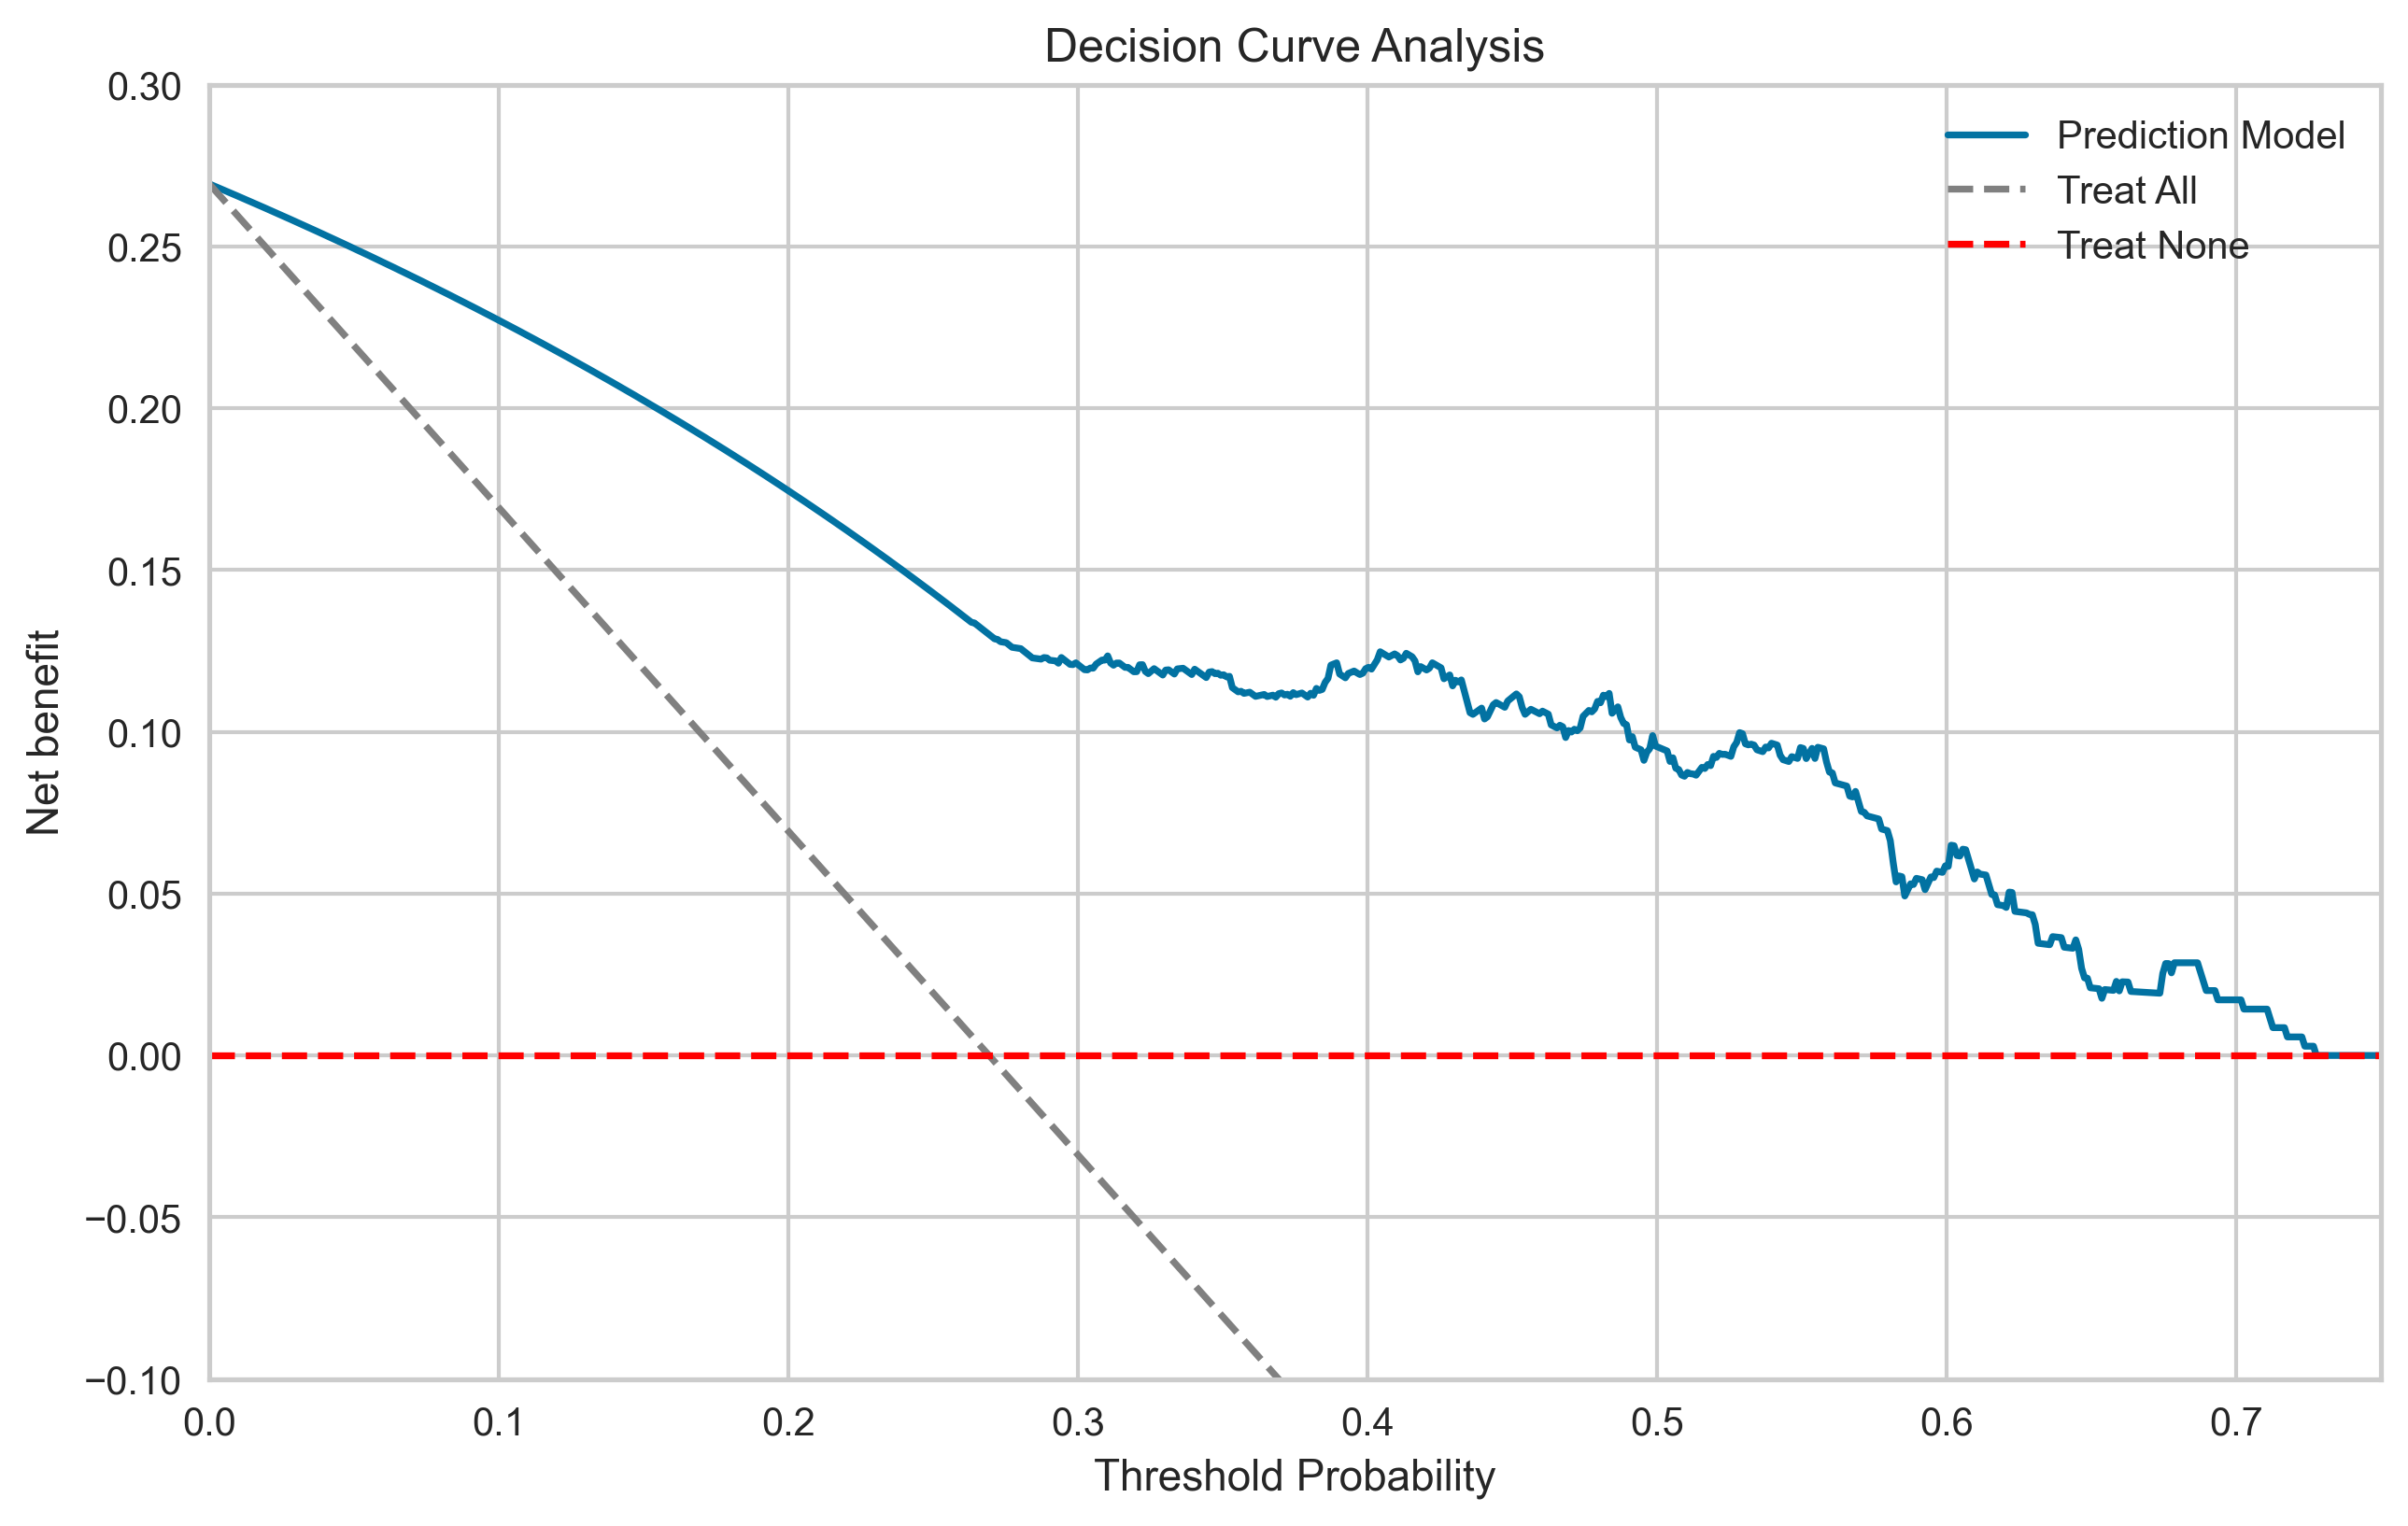

In [64]:
plt.figure(figsize=(10,6))
plt.plot(thresholds_l, net_benefits, label='Prediction Model')
plt.plot(thresholds_l, treat_all, linestyle='--', color='grey', label='Treat All')
plt.plot(thresholds_l, [0]*len(thresholds_l), linestyle='--', color='red', label='Treat None')
plt.ylim(-0.1, 0.3)
plt.xlim(0, 0.75)
plt.xlabel('Threshold Probability')
plt.ylabel('Net benefit')
plt.title('Decision Curve Analysis')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()


# Delirium vs Non-delirium : mean prediction score 계산

In [62]:
#Load raw numeric data
raw_numeric = pd.read_csv("./Data_retro_pre_median_win4_c_median_numeric_1014_raw (1).csv", index_col=0)

In [64]:
raw_numeric.columns

Index(['pid', 'sex', 'age', 'cam_time', 'cam', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'windows', 'HRs',
       'RRs', 'SpO2s'],
      dtype='object')

In [65]:
import json
len(json.loads(raw_numeric.iloc[0].SpO2s))

126

In [66]:
raw_numeric['HRs_median'] = raw_numeric.HRs.apply(lambda x: np.median(json.loads(x)))
raw_numeric['RRs_median'] = raw_numeric.RRs.apply(lambda x: np.median(json.loads(x)))
raw_numeric['SpO2s_median'] = raw_numeric.SpO2s.apply(lambda x: np.median(json.loads(x)))

In [67]:
raw_numeric['HRs_std'] = raw_numeric.HRs.apply(lambda x: np.std(json.loads(x)))
raw_numeric['RRs_std'] = raw_numeric.RRs.apply(lambda x: np.std(json.loads(x)))
raw_numeric['SpO2s_std'] = raw_numeric.SpO2s.apply(lambda x: np.std(json.loads(x)))

In [68]:
raw_waveform = pd.read_csv("./shape_features_with_pat_id.csv", index_col=0, parse_dates=['starttime','endtime'])

In [69]:
raw_waveform_pleth = raw_waveform.query('wave_type == "Pleth"')
raw_waveform_ecg = raw_waveform.query('wave_type == "II"')
raw_waveform_resp = raw_waveform.query('wave_type == "Resp"')

In [70]:
ys_data_copy = ys_data.copy()
ys_data_copy.sort_values(by=['pid','cam_time'])
ys_data_copy['rn']=ys_data_copy.groupby(by=['cam','pid']).cumcount()+1

In [71]:
import tqdm

In [72]:
hjorth_activity_win0 = []
hjorth_complexity_win0 = []
hjorth_morbidity_win0 = []
lkurtosis_win0 = []
lskewness_win0 = []

hjorth_activity_win1 = []
hjorth_complexity_win1 = []
hjorth_morbidity_win1 = []
lkurtosis_win1 = []
lskewness_win1 = []

hjorth_activity_win2 = []
hjorth_complexity_win2 = []
hjorth_morbidity_win2 = []
lkurtosis_win2 = []
lskewness_win2 = []

hjorth_activity_win3 = []
hjorth_complexity_win3 = []
hjorth_morbidity_win3 = []
lkurtosis_win3 = []
lskewness_win3 = []

for idx in tqdm.tqdm(range(len(ys_data_copy))):
    pid = ys_data_copy['pid'].iloc[idx]
    camtime = ys_data_copy['cam_time'].iloc[idx]
    camtime = pd.Timestamp(camtime)
    window0 = camtime - pd.Timedelta(4, 'hour')
    window1 = camtime - pd.Timedelta(3, 'hour')
    window2 = camtime - pd.Timedelta(2, 'hour')
    window3 = camtime - pd.Timedelta(1, 'hour')
    tmp1 = raw_waveform_ecg.query('pat_id == @pid and starttime >= @window0 and endtime <= @window1')
    tmp2 = raw_waveform_ecg.query('pat_id == @pid and starttime >= @window1 and endtime <= @window2')
    tmp3 = raw_waveform_ecg.query('pat_id == @pid and starttime >= @window2 and endtime <= @window3')
    tmp4 = raw_waveform_ecg.query('pat_id == @pid and starttime >= @window3 and endtime <= @camtime')

    act1 = tmp1.hjorth_activity.median()
    comp1 = tmp1.hjorth_complexity.median()
    morb1 = tmp1.hjorth_morbidity.median()
    lkurt1 = tmp1["kurtosis"].median()
    lskew1 = tmp1["skewness"].median()
    
    act2 = tmp2.hjorth_activity.median()
    comp2 = tmp2.hjorth_complexity.median()
    morb2 = tmp2.hjorth_morbidity.median()
    lkurt2 = tmp2["kurtosis"].median()
    lskew2 = tmp2["skewness"].median()

    act3 = tmp3.hjorth_activity.median()
    comp3 = tmp3.hjorth_complexity.median()
    morb3 = tmp3.hjorth_morbidity.median()
    lkurt3 = tmp3["kurtosis"].median()
    lskew3 = tmp3["skewness"].median()

    act4 = tmp4.hjorth_activity.median()
    comp4 = tmp4.hjorth_complexity.median()
    morb4 = tmp4.hjorth_morbidity.median()
    lkurt4 = tmp4["kurtosis"].median()
    lskew4 = tmp4["skewness"].median()

    hjorth_activity_win0.append(act1)
    hjorth_complexity_win0.append(comp1)
    hjorth_morbidity_win0.append(morb1)
    lkurtosis_win0.append(lkurt1)
    lskewness_win0.append(lskew1)

    hjorth_activity_win1.append(act2)
    hjorth_complexity_win1.append(comp2)
    hjorth_morbidity_win1.append(morb2)
    lkurtosis_win1.append(lkurt2)
    lskewness_win1.append(lskew2)
    
    hjorth_activity_win2.append(act3)
    hjorth_complexity_win2.append(comp3)
    hjorth_morbidity_win2.append(morb3)
    lkurtosis_win2.append(lkurt3)
    lskewness_win2.append(lskew3)
    
    hjorth_activity_win3.append(act4)
    hjorth_complexity_win3.append(comp4)
    hjorth_morbidity_win3.append(morb4)
    lkurtosis_win3.append(lkurt4)
    lskewness_win3.append(lskew4)
        
    
ys_data_copy["hjorth_activity_II_win0"] = hjorth_activity_win0
ys_data_copy["hjorth_complexity_II_win0"] = hjorth_complexity_win0
ys_data_copy["hjorth_morbidity_II_win0"] = hjorth_morbidity_win0
ys_data_copy["kurtosis_II_win0"] = lkurtosis_win0
ys_data_copy["skewness_II_win0"] = lskewness_win0

ys_data_copy["hjorth_activity_II_win1"] = hjorth_activity_win1
ys_data_copy["hjorth_complexity_II_win1"] = hjorth_complexity_win1
ys_data_copy["hjorth_morbidity_II_win1"] = hjorth_morbidity_win1
ys_data_copy["kurtosis_II_win1"] = lkurtosis_win1
ys_data_copy["skewness_II_win1"] = lskewness_win1

ys_data_copy["hjorth_activity_II_win2"] = hjorth_activity_win2
ys_data_copy["hjorth_complexity_II_win2"] = hjorth_complexity_win2
ys_data_copy["hjorth_morbidity_II_win2"] = hjorth_morbidity_win2
ys_data_copy["kurtosis_II_win2"] = lkurtosis_win2
ys_data_copy["skewness_II_win2"] = lskewness_win2

ys_data_copy["hjorth_activity_II_win3"] = hjorth_activity_win3
ys_data_copy["hjorth_complexity_II_win3"] = hjorth_complexity_win3
ys_data_copy["hjorth_morbidity_II_win3"] = hjorth_morbidity_win3
ys_data_copy["kurtosis_II_win3"] = lkurtosis_win3
ys_data_copy["skewness_II_win3"] = lskewness_win3


print(ys_data_copy.columns)
print(ys_data_copy.hjorth_activity_II_win3)

100%|███████████████████████████████████████| 5479/5479 [01:48<00:00, 50.65it/s]

Index(['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std', 'rn',
       'hjorth_activity_II_win0', 'hjorth_complexity_II_win0',
       'hjorth_morbidity_II_win0', 'kurtosis_II_win0', 'skewness_II_win0',
       'hjorth_activity_II_win1', 'hjorth_complexity_II_win1',
       'hjorth_morbidity_II_win1', 'kurtosis_II_win1', 'skewness_II_win1',
       'hjorth_activity_II_win2', 'hjorth_complexity_II_win2',
       'hjorth_morbidity_II_win2', 'kurtosis_II_win2', 'skewness_II_win2',
       'hjorth_activity_II_win3', 'hjorth_complexity_II_win3',
       'hjorth_morbidity_II_win3', 'kurtosis_II_win3', 'skewness_II_win3'],
      dtype='object')
0       2.233548
1       1.547786
2       2.696

In [73]:
hjorth_activity_win0 = []
hjorth_complexity_win0 = []
hjorth_morbidity_win0 = []
lkurtosis_win0 = []
lskewness_win0 = []

hjorth_activity_win1 = []
hjorth_complexity_win1 = []
hjorth_morbidity_win1 = []
lkurtosis_win1 = []
lskewness_win1 = []

hjorth_activity_win2 = []
hjorth_complexity_win2 = []
hjorth_morbidity_win2 = []
lkurtosis_win2 = []
lskewness_win2 = []

hjorth_activity_win3 = []
hjorth_complexity_win3 = []
hjorth_morbidity_win3 = []
lkurtosis_win3 = []
lskewness_win3 = []

for idx in tqdm.tqdm(range(len(ys_data_copy))):
    pid = ys_data_copy['pid'].iloc[idx]
    camtime = ys_data_copy['cam_time'].iloc[idx]
    camtime = pd.Timestamp(camtime)
    window0 = camtime - pd.Timedelta(4, 'hour')
    window1 = camtime - pd.Timedelta(3, 'hour')
    window2 = camtime - pd.Timedelta(2, 'hour')
    window3 = camtime - pd.Timedelta(1, 'hour')
    tmp1 = raw_waveform_pleth.query('pat_id == @pid and starttime >= @window0 and endtime <= @window1')
    tmp2 = raw_waveform_pleth.query('pat_id == @pid and starttime >= @window1 and endtime <= @window2')
    tmp3 = raw_waveform_pleth.query('pat_id == @pid and starttime >= @window2 and endtime <= @window3')
    tmp4 = raw_waveform_pleth.query('pat_id == @pid and starttime >= @window3 and endtime <= @camtime')

    act1 = tmp1.hjorth_activity.median()
    comp1 = tmp1.hjorth_complexity.median()
    morb1 = tmp1.hjorth_morbidity.median()
    lkurt1 = tmp1["kurtosis"].median()
    lskew1 = tmp1["skewness"].median()
    
    act2 = tmp2.hjorth_activity.median()
    comp2 = tmp2.hjorth_complexity.median()
    morb2 = tmp2.hjorth_morbidity.median()
    lkurt2 = tmp2["kurtosis"].median()
    lskew2 = tmp2["skewness"].median()

    act3 = tmp3.hjorth_activity.median()
    comp3 = tmp3.hjorth_complexity.median()
    morb3 = tmp3.hjorth_morbidity.median()
    lkurt3 = tmp3["kurtosis"].median()
    lskew3 = tmp3["skewness"].median()

    act4 = tmp4.hjorth_activity.median()
    comp4 = tmp4.hjorth_complexity.median()
    morb4 = tmp4.hjorth_morbidity.median()
    lkurt4 = tmp4["kurtosis"].median()
    lskew4 = tmp4["skewness"].median()

    hjorth_activity_win0.append(act1)
    hjorth_complexity_win0.append(comp1)
    hjorth_morbidity_win0.append(morb1)
    lkurtosis_win0.append(lkurt1)
    lskewness_win0.append(lskew1)

    hjorth_activity_win1.append(act2)
    hjorth_complexity_win1.append(comp2)
    hjorth_morbidity_win1.append(morb2)
    lkurtosis_win1.append(lkurt2)
    lskewness_win1.append(lskew2)
    
    hjorth_activity_win2.append(act3)
    hjorth_complexity_win2.append(comp3)
    hjorth_morbidity_win2.append(morb3)
    lkurtosis_win2.append(lkurt3)
    lskewness_win2.append(lskew3)
    
    hjorth_activity_win3.append(act4)
    hjorth_complexity_win3.append(comp4)
    hjorth_morbidity_win3.append(morb4)
    lkurtosis_win3.append(lkurt4)
    lskewness_win3.append(lskew4)
    
    
ys_data_copy["hjorth_activity_Pleth_win0"] = hjorth_activity_win0
ys_data_copy["hjorth_complexity_Pleth_win0"] = hjorth_complexity_win0
ys_data_copy["hjorth_morbidity_Pleth_win0"] = hjorth_morbidity_win0
ys_data_copy["kurtosis_Pleth_win0"] = lkurtosis_win0
ys_data_copy["skewness_Pleth_win0"] = lskewness_win0

ys_data_copy["hjorth_activity_Pleth_win1"] = hjorth_activity_win1
ys_data_copy["hjorth_complexity_Pleth_win1"] = hjorth_complexity_win1
ys_data_copy["hjorth_morbidity_Pleth_win1"] = hjorth_morbidity_win1
ys_data_copy["kurtosis_Pleth_win1"] = lkurtosis_win1
ys_data_copy["skewness_Pleth_win1"] = lskewness_win1

ys_data_copy["hjorth_activity_Pleth_win2"] = hjorth_activity_win2
ys_data_copy["hjorth_complexity_Pleth_win2"] = hjorth_complexity_win2
ys_data_copy["hjorth_morbidity_Pleth_win2"] = hjorth_morbidity_win2
ys_data_copy["kurtosis_Pleth_win2"] = lkurtosis_win2
ys_data_copy["skewness_Pleth_win2"] = lskewness_win2

ys_data_copy["hjorth_activity_Pleth_win3"] = hjorth_activity_win3
ys_data_copy["hjorth_complexity_Pleth_win3"] = hjorth_complexity_win3
ys_data_copy["hjorth_morbidity_Pleth_win3"] = hjorth_morbidity_win3
ys_data_copy["kurtosis_Pleth_win3"] = lkurtosis_win3
ys_data_copy["skewness_Pleth_win3"] = lskewness_win3

100%|███████████████████████████████████████| 5479/5479 [01:49<00:00, 50.22it/s]


In [74]:
hjorth_activity_win0 = []
hjorth_complexity_win0 = []
hjorth_morbidity_win0 = []
lkurtosis_win0 = []
lskewness_win0 = []

hjorth_activity_win1 = []
hjorth_complexity_win1 = []
hjorth_morbidity_win1 = []
lkurtosis_win1 = []
lskewness_win1 = []

hjorth_activity_win2 = []
hjorth_complexity_win2 = []
hjorth_morbidity_win2 = []
lkurtosis_win2 = []
lskewness_win2 = []

hjorth_activity_win3 = []
hjorth_complexity_win3 = []
hjorth_morbidity_win3 = []
lkurtosis_win3 = []
lskewness_win3 = []

for idx in tqdm.tqdm(range(len(ys_data_copy))):
    pid = ys_data_copy['pid'].iloc[idx]
    camtime = ys_data_copy['cam_time'].iloc[idx]
    camtime = pd.Timestamp(camtime)
    window0 = camtime - pd.Timedelta(4, 'hour')
    window1 = camtime - pd.Timedelta(3, 'hour')
    window2 = camtime - pd.Timedelta(2, 'hour')
    window3 = camtime - pd.Timedelta(1, 'hour')
    tmp1 = raw_waveform_resp.query('pat_id == @pid and starttime >= @window0 and endtime <= @window1')
    tmp2 = raw_waveform_resp.query('pat_id == @pid and starttime >= @window1 and endtime <= @window2')
    tmp3 = raw_waveform_resp.query('pat_id == @pid and starttime >= @window2 and endtime <= @window3')
    tmp4 = raw_waveform_resp.query('pat_id == @pid and starttime >= @window3 and endtime <= @camtime')

    act1 = tmp1.hjorth_activity.median()
    comp1 = tmp1.hjorth_complexity.median()
    morb1 = tmp1.hjorth_morbidity.median()
    lkurt1 = tmp1["kurtosis"].median()
    lskew1 = tmp1["skewness"].median()
    
    act2 = tmp2.hjorth_activity.median()
    comp2 = tmp2.hjorth_complexity.median()
    morb2 = tmp2.hjorth_morbidity.median()
    lkurt2 = tmp2["kurtosis"].median()
    lskew2 = tmp2["skewness"].median()

    act3 = tmp3.hjorth_activity.median()
    comp3 = tmp3.hjorth_complexity.median()
    morb3 = tmp3.hjorth_morbidity.median()
    lkurt3 = tmp3["kurtosis"].median()
    lskew3 = tmp3["skewness"].median()

    act4 = tmp4.hjorth_activity.median()
    comp4 = tmp4.hjorth_complexity.median()
    morb4 = tmp4.hjorth_morbidity.median()
    lkurt4 = tmp4["kurtosis"].median()
    lskew4 = tmp4["skewness"].median()

    hjorth_activity_win0.append(act1)
    hjorth_complexity_win0.append(comp1)
    hjorth_morbidity_win0.append(morb1)
    lkurtosis_win0.append(lkurt1)
    lskewness_win0.append(lskew1)

    hjorth_activity_win1.append(act2)
    hjorth_complexity_win1.append(comp2)
    hjorth_morbidity_win1.append(morb2)
    lkurtosis_win1.append(lkurt2)
    lskewness_win1.append(lskew2)
    
    hjorth_activity_win2.append(act3)
    hjorth_complexity_win2.append(comp3)
    hjorth_morbidity_win2.append(morb3)
    lkurtosis_win2.append(lkurt3)
    lskewness_win2.append(lskew3)
    
    hjorth_activity_win3.append(act4)
    hjorth_complexity_win3.append(comp4)
    hjorth_morbidity_win3.append(morb4)
    lkurtosis_win3.append(lkurt4)
    lskewness_win3.append(lskew4)
    
    
ys_data_copy["hjorth_activity_Resp_win0"] = hjorth_activity_win0
ys_data_copy["hjorth_complexity_Resp_win0"] = hjorth_complexity_win0
ys_data_copy["hjorth_morbidity_Resp_win0"] = hjorth_morbidity_win0
ys_data_copy["kurtosis_Resp_win0"] = lkurtosis_win0
ys_data_copy["skewness_Resp_win0"] = lskewness_win0

ys_data_copy["hjorth_activity_Resp_win1"] = hjorth_activity_win1
ys_data_copy["hjorth_complexity_Resp_win1"] = hjorth_complexity_win1
ys_data_copy["hjorth_morbidity_Resp_win1"] = hjorth_morbidity_win1
ys_data_copy["kurtosis_Resp_win1"] = lkurtosis_win1
ys_data_copy["skewness_Resp_win1"] = lskewness_win1

ys_data_copy["hjorth_activity_Resp_win2"] = hjorth_activity_win2
ys_data_copy["hjorth_complexity_Resp_win2"] = hjorth_complexity_win2
ys_data_copy["hjorth_morbidity_Resp_win2"] = hjorth_morbidity_win2
ys_data_copy["kurtosis_Resp_win2"] = lkurtosis_win2
ys_data_copy["skewness_Resp_win2"] = lskewness_win2

ys_data_copy["hjorth_activity_Resp_win3"] = hjorth_activity_win3
ys_data_copy["hjorth_complexity_Resp_win3"] = hjorth_complexity_win3
ys_data_copy["hjorth_morbidity_Resp_win3"] = hjorth_morbidity_win3
ys_data_copy["kurtosis_Resp_win3"] = lkurtosis_win3
ys_data_copy["skewness_Resp_win3"] = lskewness_win3

100%|███████████████████████████████████████| 5479/5479 [02:02<00:00, 44.59it/s]


#### window 별로 df 쪼개기

In [75]:
raw_numeric_0 = raw_numeric.query("windows == 0")
raw_numeric_1 = raw_numeric.query("windows == 1")
raw_numeric_2 = raw_numeric.query("windows == 2")
raw_numeric_3 = raw_numeric.query("windows == 3")

In [76]:
ys_data_copy_0 = ys_data_copy[['pid', 'cam_time', 'cam', 'sex', 'age', 
       'hjorth_activity_II_win0', 'hjorth_complexity_II_win0',
       'hjorth_morbidity_II_win0', 'kurtosis_II_win0', 'skewness_II_win0',
       'hjorth_activity_Pleth_win0', 'hjorth_complexity_Pleth_win0',
       'hjorth_morbidity_Pleth_win0', 'kurtosis_Pleth_win0',
       'skewness_Pleth_win0','hjorth_activity_Resp_win0', 'hjorth_complexity_Resp_win0',
       'hjorth_morbidity_Resp_win0', 'kurtosis_Resp_win0',
       'skewness_Resp_win0']]
ys_data_copy_1 = ys_data_copy[['pid', 'cam_time', 'cam', 'sex', 'age', 
       'hjorth_activity_II_win1', 'hjorth_complexity_II_win1',
       'hjorth_morbidity_II_win1', 'kurtosis_II_win1', 'skewness_II_win1',
       'hjorth_activity_Pleth_win1', 'hjorth_complexity_Pleth_win1',
       'hjorth_morbidity_Pleth_win1', 'kurtosis_Pleth_win1',
       'skewness_Pleth_win1','hjorth_activity_Resp_win1', 'hjorth_complexity_Resp_win1',
       'hjorth_morbidity_Resp_win1', 'kurtosis_Resp_win1',
       'skewness_Resp_win1']]
ys_data_copy_2 = ys_data_copy[['pid', 'cam_time', 'cam', 'sex', 'age', 
       'hjorth_activity_II_win2', 'hjorth_complexity_II_win2',
       'hjorth_morbidity_II_win2', 'kurtosis_II_win2', 'skewness_II_win2',
       'hjorth_activity_Pleth_win2', 'hjorth_complexity_Pleth_win2',
       'hjorth_morbidity_Pleth_win2', 'kurtosis_Pleth_win2',
       'skewness_Pleth_win2','hjorth_activity_Resp_win2', 'hjorth_complexity_Resp_win2',
       'hjorth_morbidity_Resp_win2', 'kurtosis_Resp_win2',
       'skewness_Resp_win2']]
ys_data_copy_3 = ys_data_copy[['pid', 'cam_time', 'cam', 'sex', 'age', 
       'hjorth_activity_II_win3', 'hjorth_complexity_II_win3',
       'hjorth_morbidity_II_win3', 'kurtosis_II_win3', 'skewness_II_win3',
       'hjorth_activity_Pleth_win3', 'hjorth_complexity_Pleth_win3',
       'hjorth_morbidity_Pleth_win3', 'kurtosis_Pleth_win3',
       'skewness_Pleth_win3','hjorth_activity_Resp_win3', 'hjorth_complexity_Resp_win3',
       'hjorth_morbidity_Resp_win3', 'kurtosis_Resp_win3',

                               'skewness_Resp_win3']]

In [77]:
raw_numeric_0['cam_time'] = pd.to_datetime(raw_numeric_0.cam_time)
raw_numeric_1['cam_time'] = pd.to_datetime(raw_numeric_1.cam_time)
raw_numeric_2['cam_time'] = pd.to_datetime(raw_numeric_2.cam_time)
raw_numeric_3['cam_time'] = pd.to_datetime(raw_numeric_3.cam_time)

In [78]:
ys_data_copy_0['cam_time'] = pd.to_datetime(ys_data_copy_0.cam_time)
ys_data_copy_1['cam_time'] = pd.to_datetime(ys_data_copy_1.cam_time)
ys_data_copy_2['cam_time'] = pd.to_datetime(ys_data_copy_2.cam_time)
ys_data_copy_3['cam_time'] = pd.to_datetime(ys_data_copy_3.cam_time)

In [79]:
window_0_df = ys_data_copy_0.merge(raw_numeric_0, on=['pid','cam_time'])
window_1_df = ys_data_copy_1.merge(raw_numeric_1, on=['pid','cam_time'])
window_2_df = ys_data_copy_2.merge(raw_numeric_2, on=['pid','cam_time'])
window_3_df = ys_data_copy_3.merge(raw_numeric_3, on=['pid','cam_time'])

In [80]:
# ['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
#        'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
#        'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
#        'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
#        'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']

window_0_df = window_0_df[['pid', 'cam_time', 'cam_x', 'sex_x', 'age_x', 'hjorth_activity_II_win0', 
                        'hjorth_activity_Pleth_win0','hjorth_activity_Resp_win0','hjorth_complexity_II_win0', 
                        'hjorth_morbidity_II_win0','kurtosis_II_win0', 'kurtosis_Pleth_win0', 'kurtosis_Resp_win0', 
                        'skewness_II_win0', 'skewness_Pleth_win0', 'skewness_Resp_win0', 'HRs_median', 'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']]


window_0_df.columns = ['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']


window_1_df = window_1_df[['pid', 'cam_time', 'cam_x', 'sex_x', 'age_x', 'hjorth_activity_II_win1', 
                        'hjorth_activity_Pleth_win1','hjorth_activity_Resp_win1','hjorth_complexity_II_win1', 
                        'hjorth_morbidity_II_win1','kurtosis_II_win1', 'kurtosis_Pleth_win1', 'kurtosis_Resp_win1', 
                        'skewness_II_win1', 'skewness_Pleth_win1', 'skewness_Resp_win1', 'HRs_median', 'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']]


window_1_df.columns = ['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']



window_2_df = window_2_df[['pid', 'cam_time', 'cam_x', 'sex_x', 'age_x', 'hjorth_activity_II_win2', 
                        'hjorth_activity_Pleth_win2','hjorth_activity_Resp_win2','hjorth_complexity_II_win2', 
                        'hjorth_morbidity_II_win2','kurtosis_II_win2', 'kurtosis_Pleth_win2', 'kurtosis_Resp_win2', 
                        'skewness_II_win2', 'skewness_Pleth_win2', 'skewness_Resp_win2', 'HRs_median', 'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']]


window_2_df.columns = ['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']



window_3_df = window_3_df[['pid', 'cam_time', 'cam_x', 'sex_x', 'age_x', 'hjorth_activity_II_win3', 
                        'hjorth_activity_Pleth_win3','hjorth_activity_Resp_win3','hjorth_complexity_II_win3', 
                        'hjorth_morbidity_II_win3','kurtosis_II_win3', 'kurtosis_Pleth_win3', 'kurtosis_Resp_win3', 
                        'skewness_II_win3', 'skewness_Pleth_win3', 'skewness_Resp_win3', 'HRs_median', 'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']]


window_3_df.columns = ['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']



In [81]:
prediction_w0 = predict_model(model, data=window_0_df)
prediction_w0.loc[prediction_w0["prediction_label"]==0,'prediction_score']=1-prediction_w0[prediction_w0["prediction_label"]==0]["prediction_score"]

prediction_w1 = predict_model(model, data=window_1_df)
prediction_w1.loc[prediction_w1["prediction_label"]==0,'prediction_score']=1-prediction_w1[prediction_w1["prediction_label"]==0]["prediction_score"]

prediction_w2 = predict_model(model, data=window_2_df)
prediction_w2.loc[prediction_w2["prediction_label"]==0,'prediction_score']=1-prediction_w2[prediction_w2["prediction_label"]==0]["prediction_score"]

prediction_w3 = predict_model(model, data=window_3_df)
prediction_w3.loc[prediction_w3["prediction_label"]==0,'prediction_score']=1-prediction_w3[prediction_w3["prediction_label"]==0]["prediction_score"]

### 이제 다시 column으로 합체시키기

In [82]:
prediction_w0 = prediction_w0[['pid','cam_time','prediction_score']]
prediction_w1 = prediction_w1[['pid','cam_time','prediction_score']]
prediction_w2 = prediction_w2[['pid','cam_time','prediction_score']]
prediction_w3 = prediction_w3[['pid','cam_time','prediction_score']]

In [83]:
prediction_w0.columns = ['pid','cam_time','Score_0']
prediction_w1.columns = ['pid','cam_time','Score_1']
prediction_w2.columns = ['pid','cam_time','Score_2']
prediction_w3.columns = ['pid','cam_time','Score_3']

In [84]:
ys_data_copy['cam_time'] = pd.to_datetime(ys_data_copy.cam_time)

In [85]:
ys_data_copy = ys_data_copy.merge(prediction_w0, on=['pid','cam_time'])
ys_data_copy = ys_data_copy.drop_duplicates()

In [86]:
ys_data_copy = ys_data_copy.merge(prediction_w1, on=['pid','cam_time'])
ys_data_copy = ys_data_copy.drop_duplicates()

In [87]:
ys_data_copy = ys_data_copy.merge(prediction_w2, on=['pid','cam_time'])
ys_data_copy = ys_data_copy.drop_duplicates()

In [88]:
ys_data_copy = ys_data_copy.merge(prediction_w3, on=['pid','cam_time'])
ys_data_copy = ys_data_copy.drop_duplicates()

In [89]:
ys_data_copy.columns

Index(['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std', 'rn',
       'hjorth_activity_II_win0', 'hjorth_complexity_II_win0',
       'hjorth_morbidity_II_win0', 'kurtosis_II_win0', 'skewness_II_win0',
       'hjorth_activity_II_win1', 'hjorth_complexity_II_win1',
       'hjorth_morbidity_II_win1', 'kurtosis_II_win1', 'skewness_II_win1',
       'hjorth_activity_II_win2', 'hjorth_complexity_II_win2',
       'hjorth_morbidity_II_win2', 'kurtosis_II_win2', 'skewness_II_win2',
       'hjorth_activity_II_win3', 'hjorth_complexity_II_win3',
       'hjorth_morbidity_II_win3', 'kurtosis_II_win3', 'skewness_II_win3',
       'hjorth_activity_Pleth_win0', 'hjorth_complexity_Pleth_win0',
 

In [90]:
ys_data_copy = ys_data_copy[['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std', 'rn',
       'Score_0', 'Score_1', 'Score_2', 'Score_3']]

In [91]:
ys_data_copy = ys_data_copy.drop_duplicates()

### Plotting

In [92]:
from matplotlib import pyplot as plt
import numpy as np

In [93]:
def plot_with_score(df,pid):
    y = []
    x = []
    c = []
    tmpdf = pd.DataFrame(columns=["cam_time","Score"])
    for idx in (df.query("pid == {}".format(pid)).sort_values(by=['cam_time']).index):
        w0 = df.query("pid == {0}".format(pid))["Score_0"][idx]
        w1 = df.query("pid == {0}".format(pid))["Score_1"][idx]
        w2 = df.query("pid == {0}".format(pid))["Score_2"][idx]
        w3 = df.query("pid == {0}".format(pid))["Score_3"][idx]
        cam_rslt = df.query("pid == {0}".format(pid))["cam"][idx]
        x.append("")
        x.append("")
        x.append("")
        c.append(2)
        c.append(2)
        c.append(2)
        c.append(cam_rslt)
        x.append(str(df.query("pid == {0}".format(pid))["cam_time"][idx]))
        y.append(w0)
        y.append(w1)
        y.append(w2)
        y.append(w3)
    tmpdf["cam_time"] = x
    tmpdf["Score"] = y
    tmpdf["cam_icu"] = c

    fig = plt.figure(figsize=(20, 10))
    fig.set_dpi(300.0)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticklabels(tmpdf["cam_time"], fontsize=12)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    
    # cam_icu 결과에 따른 따른 색상 지정
    color_mapping = {1: 'red', 0: 'blue', 2: 'black'}
    colors = tmpdf['cam_icu'].map(color_mapping)
    # Seaborn 스타일 설정
    sns.set_style('whitegrid')

    plt.ylim([0,1])
    #plt.yticks(y)
    plt.xticks(tmpdf.index)
    plt.xticks(rotation=45)

    plt.scatter(tmpdf.index, tmpdf['Score'], marker='o', c=colors)
    plt.plot(tmpdf.index, tmpdf['Score'])
    print(pid)
    
    #plt.savefig('/Users/charmbong/Documents/Delirium/논문/figure/{0}.png'.format(pid))

In [94]:
#ys_data_copy = ys_data.copy()
ys_data_copy.sort_values(by=['pid','cam_time'])
ys_data_copy['rn']=ys_data_copy.groupby(by=['cam','pid']).cumcount()+1

In [336]:
onset_list = ys_data_copy.query("cam == 1 and rn >= 2").pid.unique().tolist()
onset_list = ys_data_copy.query("pid in @onset_list and cam == 0").pid.unique().tolist()

In [45]:
ex_data = pd.read_csv("./ext_val.csv", index_col = 0)

In [46]:
ex_data = ex_data[['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']]

In [47]:
tmp_data = tv[['pid', 'cam_time', 'cam', 'sex', 'age', 'hjorth_activity_II',
       'hjorth_activity_Pleth', 'hjorth_activity_Resp', 'hjorth_complexity_II',
       'hjorth_morbidity_II', 'kurtosis_II', 'kurtosis_Pleth', 'kurtosis_Resp',
       'skewness_II', 'skewness_Pleth', 'skewness_Resp', 'HRs_median',
       'RRs_median', 'SpO2s_median', 'HRs_std', 'RRs_std', 'SpO2s_std']]

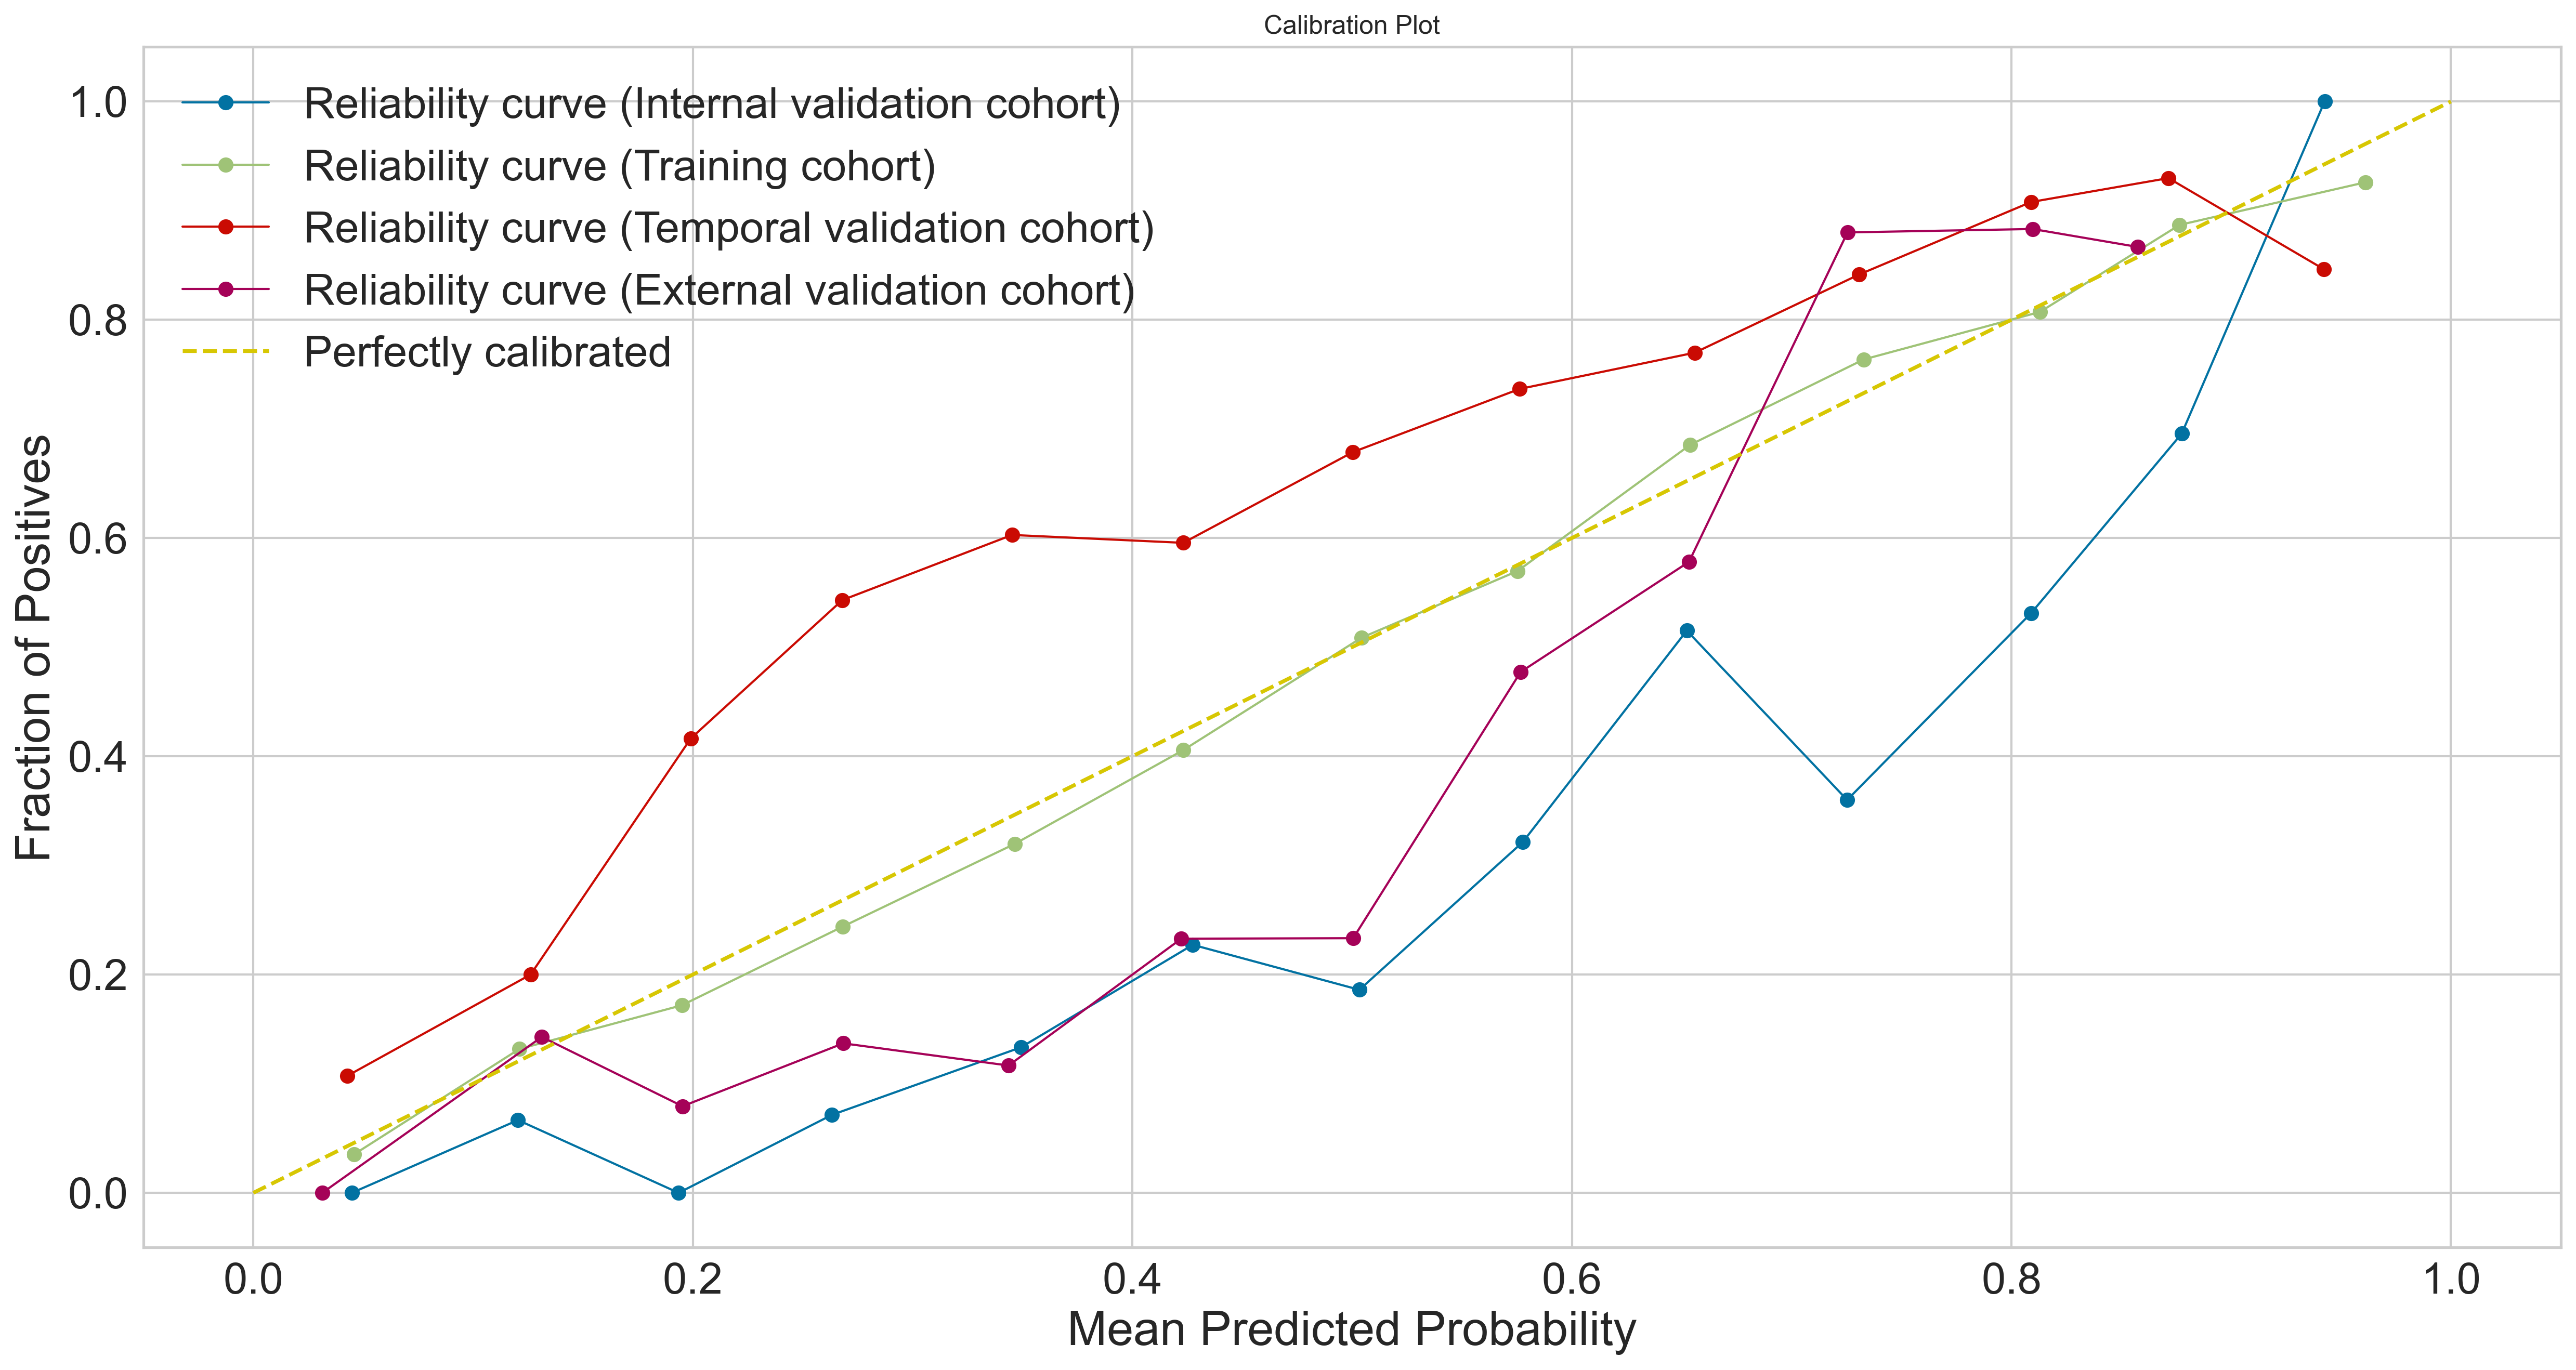

In [47]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt



# Assuming you have your external validation set as external_X, external_y
# And your model is 'calibrated'
probabilities = calibrated_model.predict_proba(test_data.iloc[:,3:])[:, 1]
probabilities_tr = calibrated_model.predict_proba(train_data.iloc[:,3:])[:, 1]
probabilities_tmp = calibrated_model.predict_proba(tmp_data.iloc[:,3:])[:, 1]
probabilities_ex = calibrated_model.predict_proba(ex_data.iloc[:,3:])[:, 1]

prob_true, prob_pred = calibration_curve(test_data.iloc[:,2], probabilities, n_bins=13)
prob_true_tr, prob_pred_tr = calibration_curve(train_data.iloc[:,2], probabilities_tr, n_bins=13)
prob_true_ex, prob_pred_ex = calibration_curve(ex_data.iloc[:,2], probabilities_ex, n_bins=13)
prob_true_tmp, prob_pred_tmp = calibration_curve(tmp_data.iloc[:,2], probabilities_tmp, n_bins=13)


fig = plt.figure(figsize=(20, 10))
fig.set_dpi(300.0)
ax = fig.add_subplot(1, 1, 1)
sns.set_style("whitegrid")

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Reliability curve (Internal validation cohort)')
plt.plot(prob_pred_tr, prob_true_tr, marker='o', linewidth=1, label='Reliability curve (Training cohort)')
plt.plot(prob_pred_tmp, prob_true_tmp, marker='o', linewidth=1, label='Reliability curve (Temporal validation cohort)')
plt.plot(prob_pred_ex, prob_true_ex, marker='o', linewidth=1, label='Reliability curve (External validation cohort)')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.xlabel('Mean Predicted Probability', fontsize=22)
plt.ylabel('Fraction of Positives', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Customize font size for legend
plt.legend(fontsize=20)
plt.show()


# Revision - Benchmarking

In [56]:
et = create_model('et')
lr = create_model('lr')
xgboost = create_model('xgboost')

In [55]:
lgbm = create_model('lightgbm', n_jobs=1)

In [57]:
tuned_et = tune_model(et)
tuned_lr = tune_model(lr)
tuned_xgb = tune_model(xgboost)
tuned_lgbm = tune_model(lgbm)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [58]:
benchmark_et = predict_model(et, data=test_data)
benchmark_xgb = predict_model(tuned_xgb, data=test_data)
benchmark_lr = predict_model(lr, data=test_data)
benchmark_lgbm = predict_model(lgbm, data=test_data)

In [59]:
def score_recalculate(df):
    df = df
    df.loc[df["prediction_label"]==0, "prediction_score"] = 1-df[df["prediction_label"]==0]["prediction_score"]
    
    return df

In [60]:
benchmark_xgb = score_recalculate(benchmark_xgb)
bemchmark_lr = score_recalculate(benchmark_lr)
benchmark_lgbm = score_recalculate(benchmark_lgbm)
benchmark_et = score_recalculate(benchmark_et)

In [61]:
from scipy.signal import savgol_filter
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score,precision_recall_curve

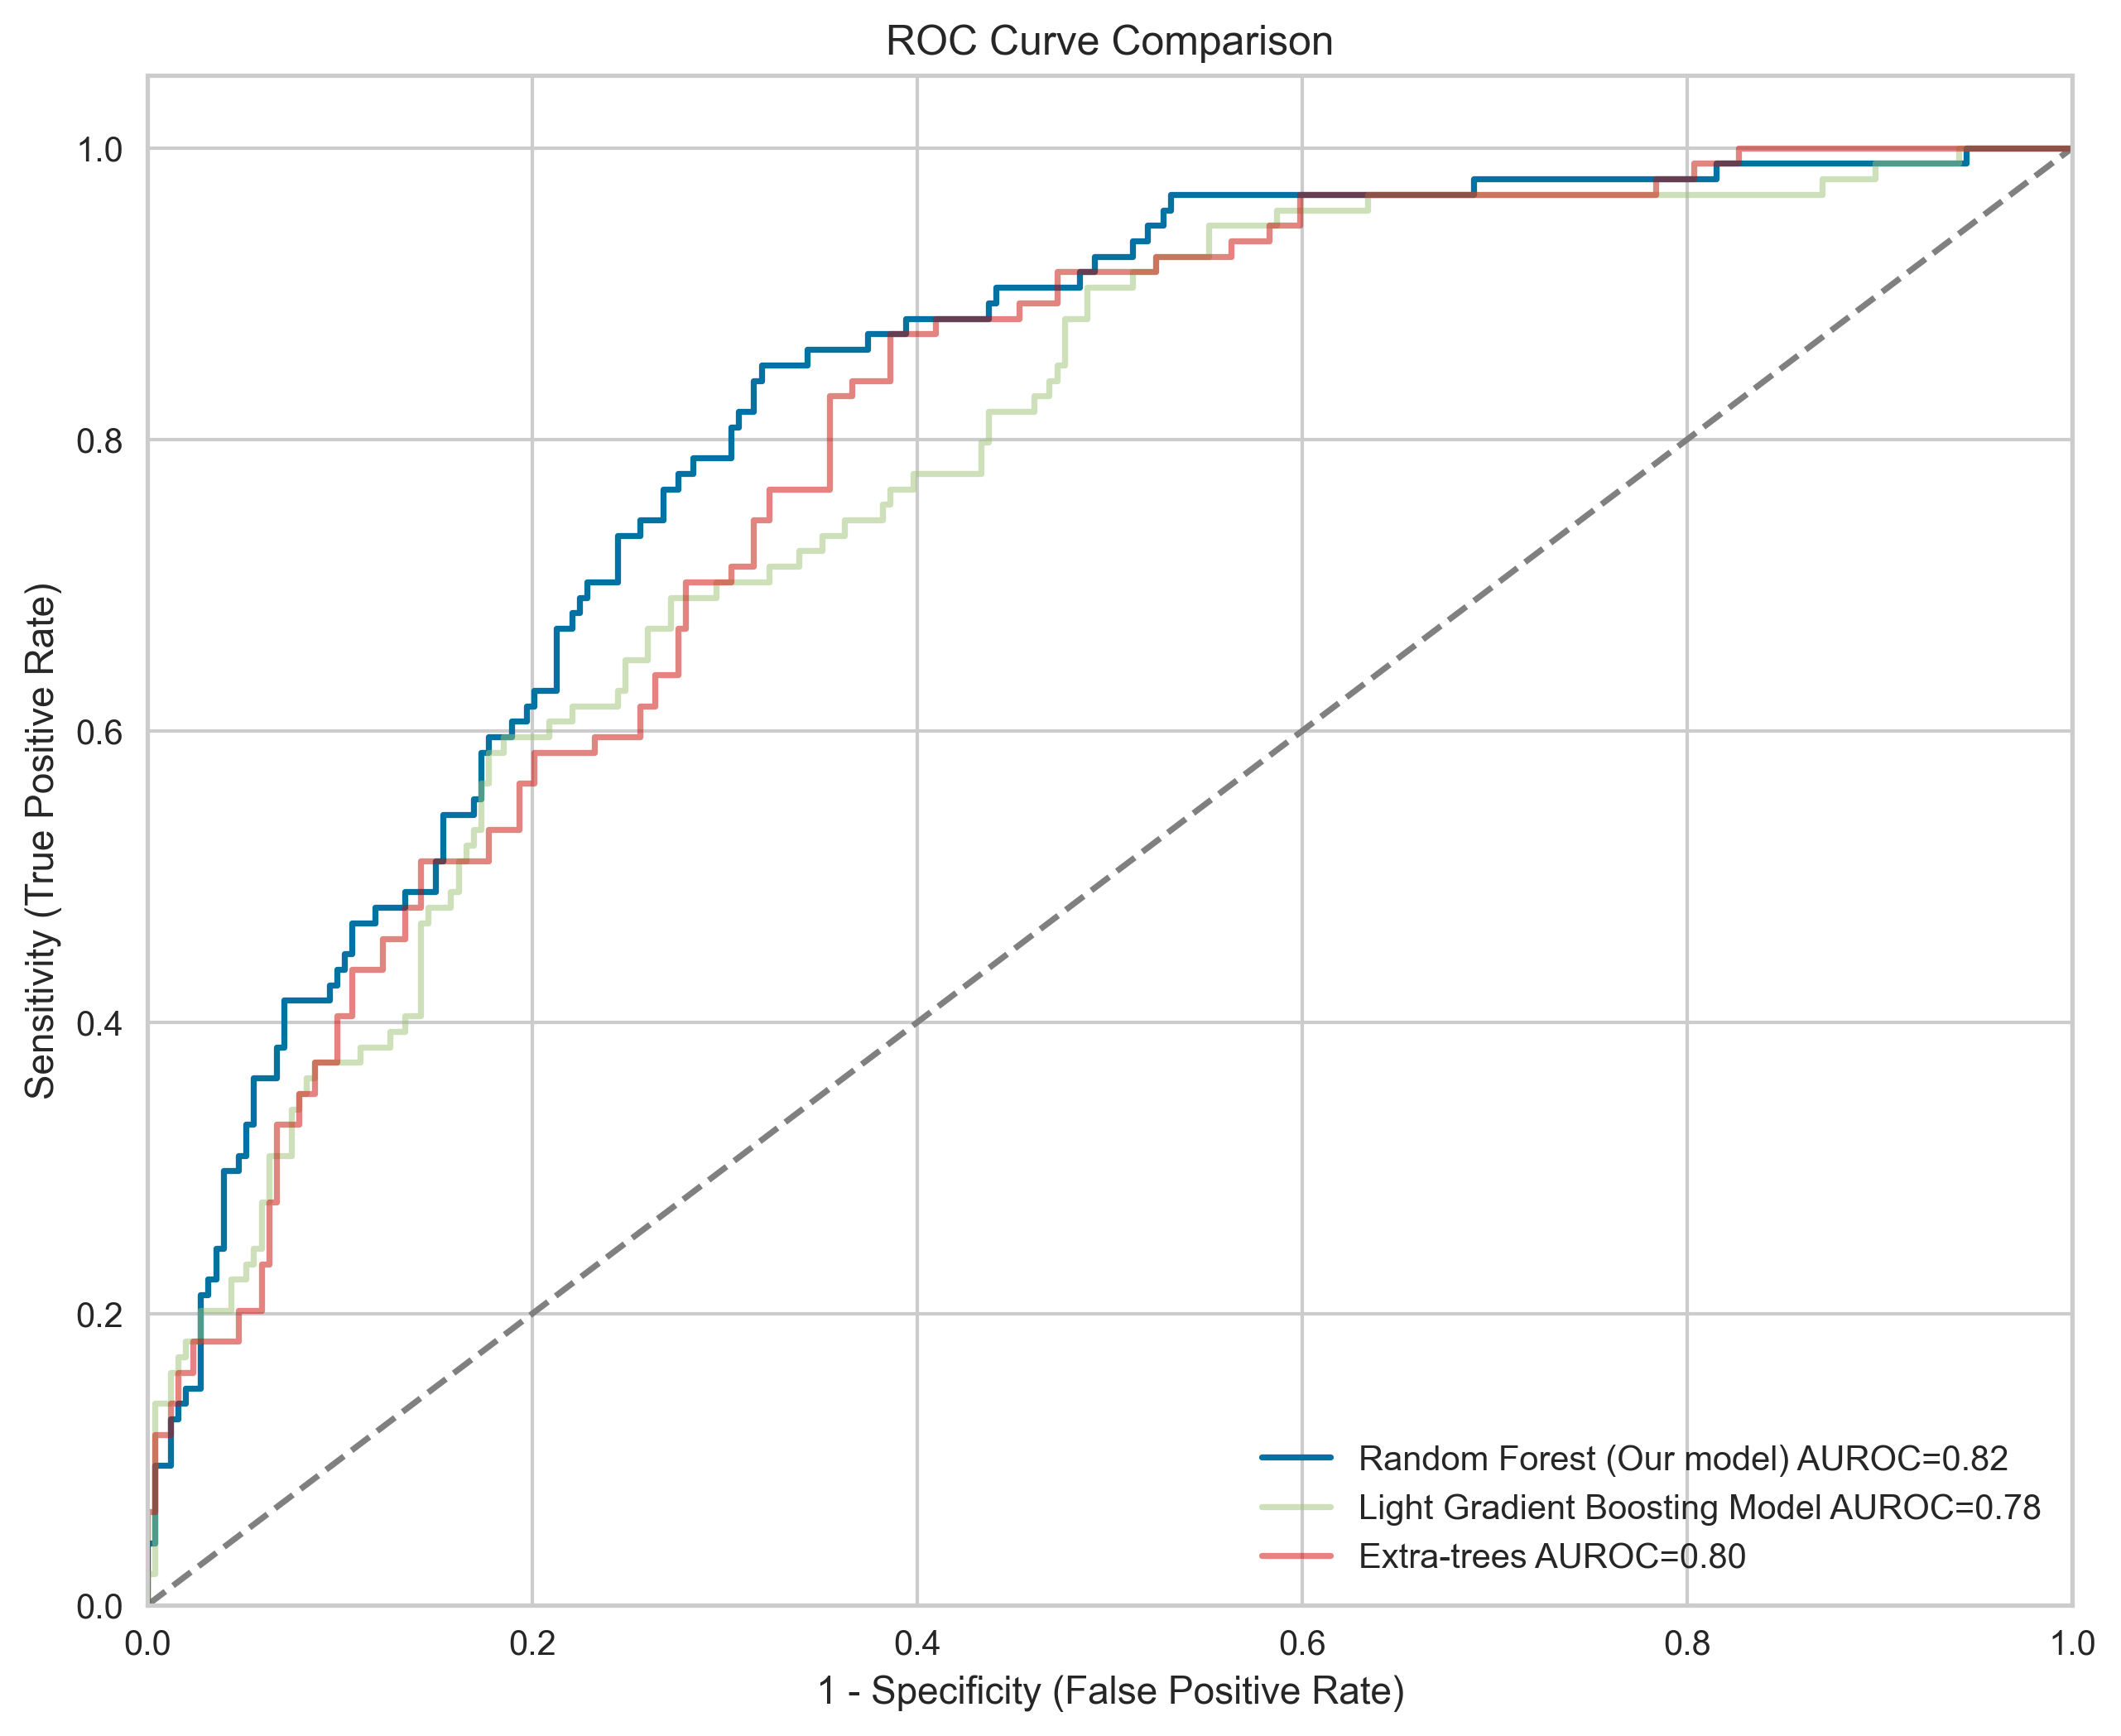

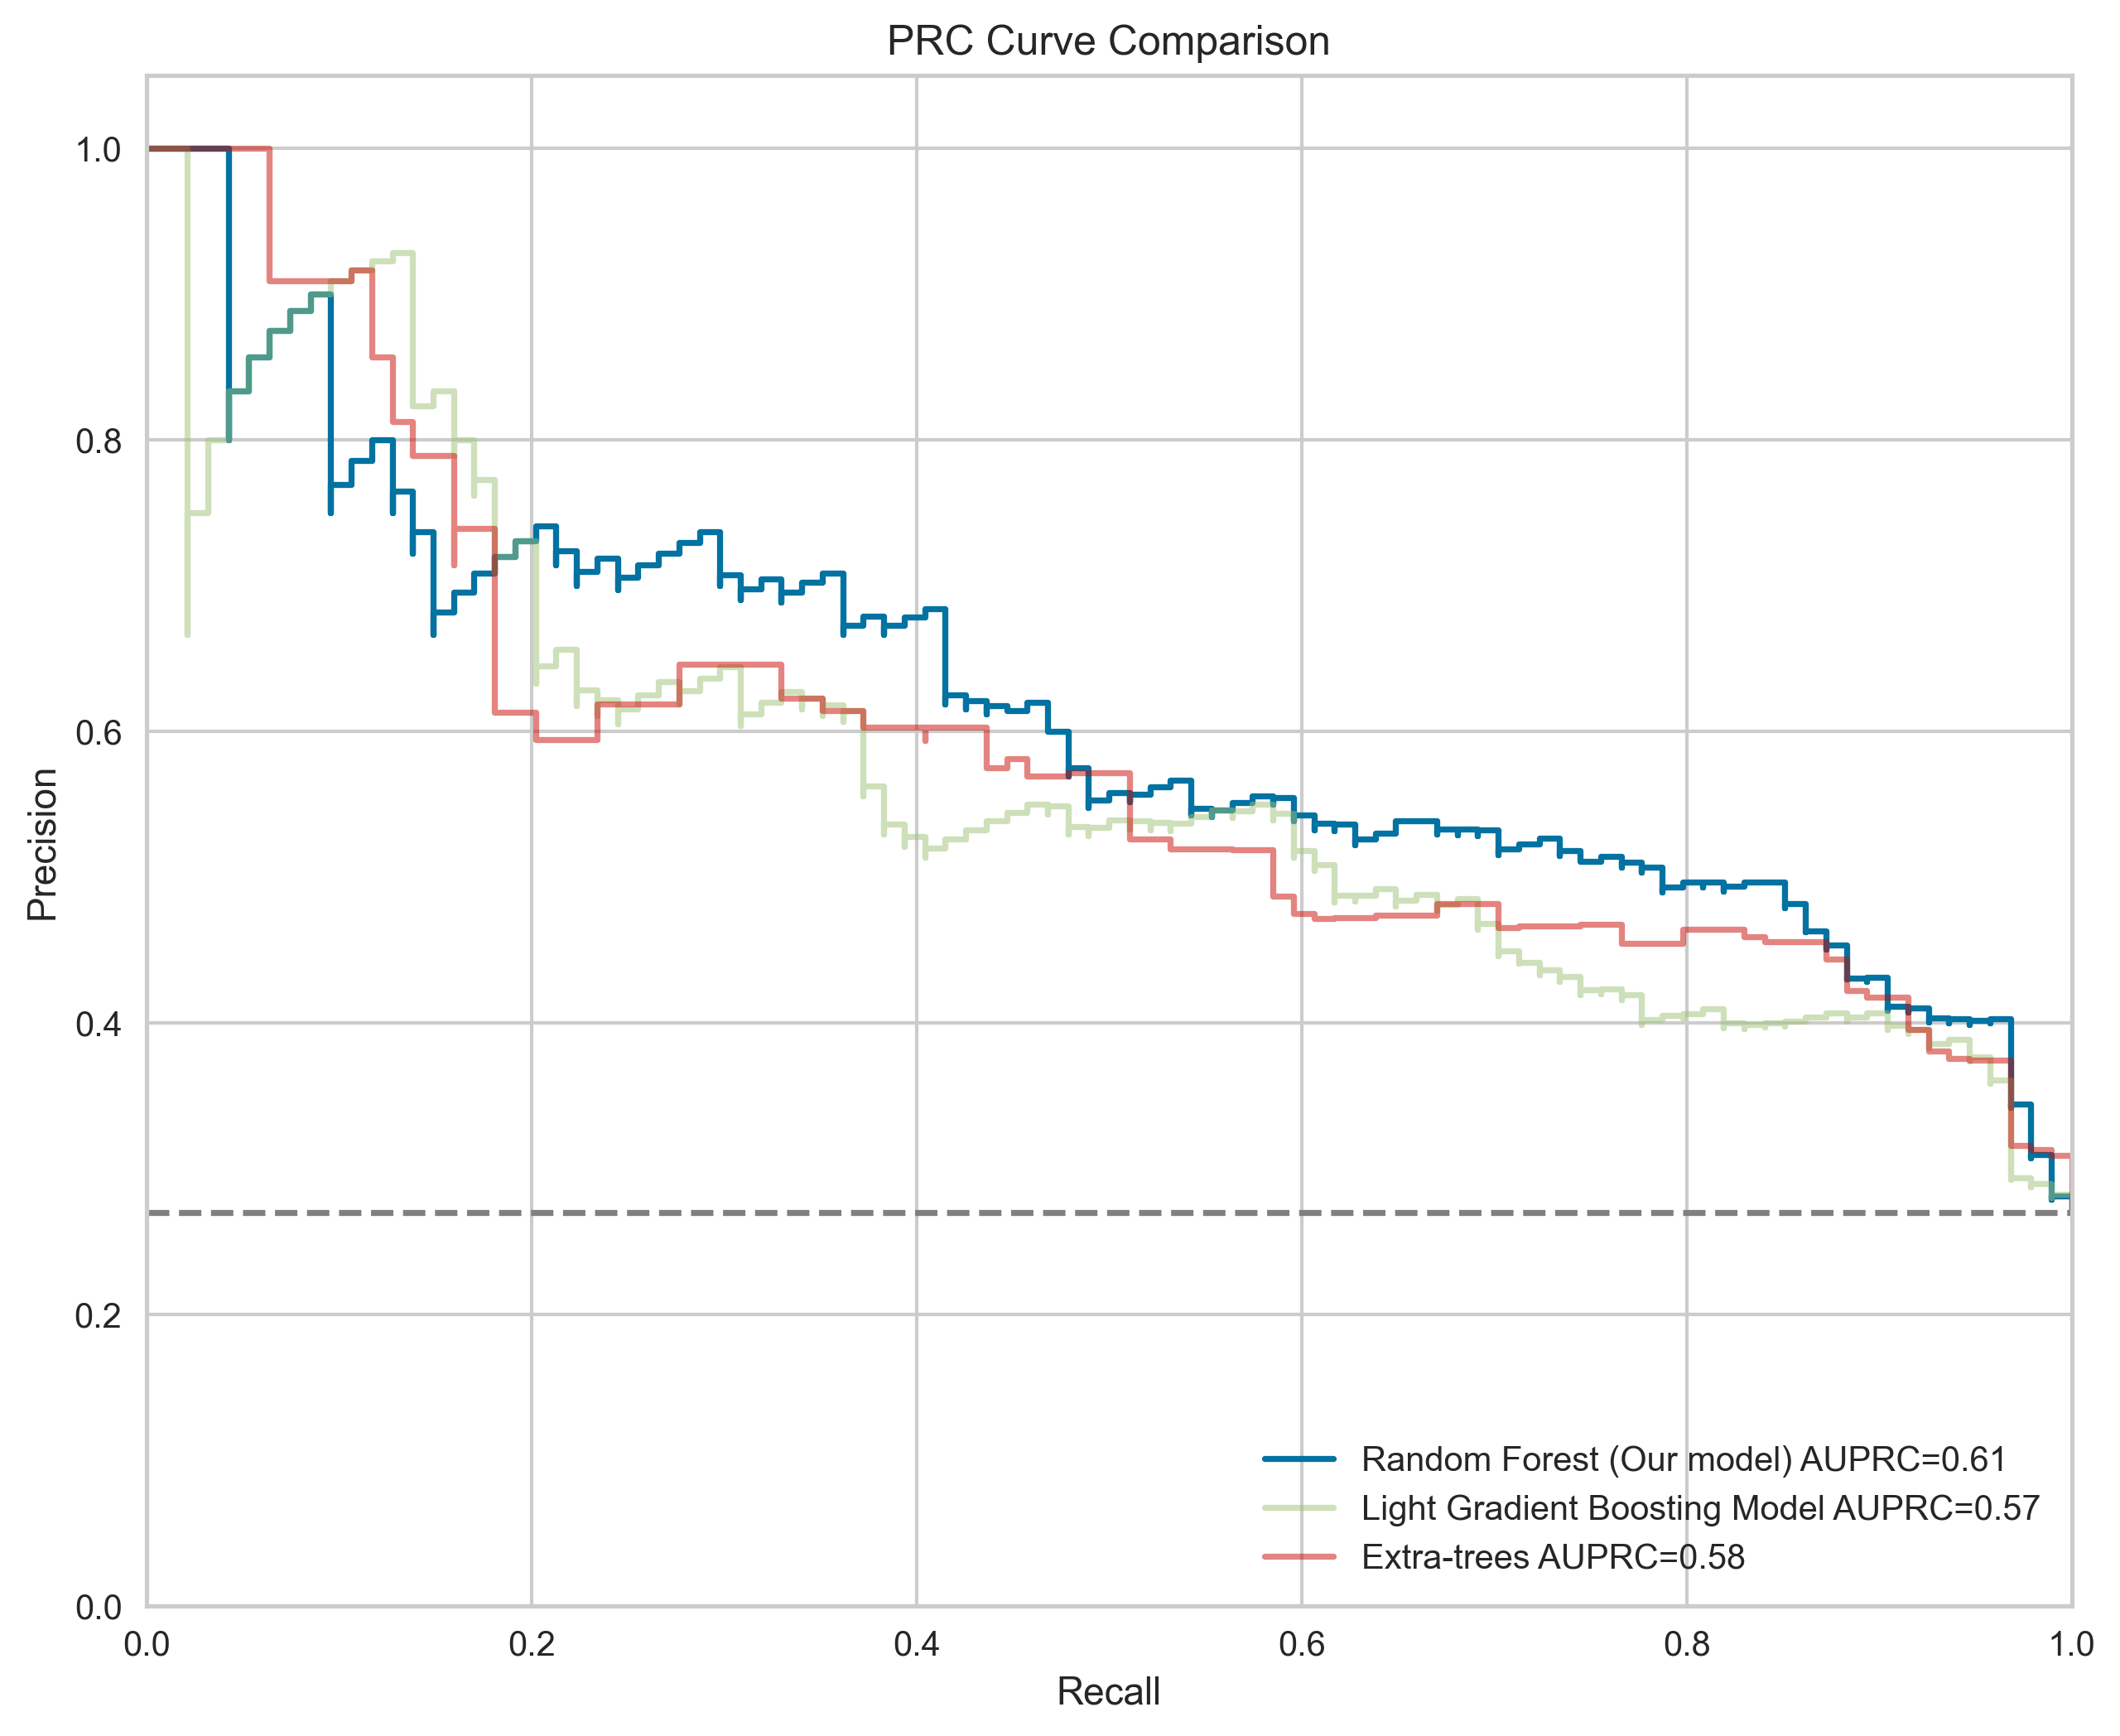

In [63]:
def get_roc_graph(dataframes, labels):
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Add a dashed diagonal line

    colors = ['b', 'g', 'r', 'orange', 'purple']  # Blue, Green, Red, Cyan, Magenta, Yellow, Black
    color_iter = iter(colors)    
    for df, label in zip(dataframes, labels):
        if label=='Random Forest (Our model)':
            roc_score = roc_auc_score(df['cam'], df['prediction_score'])
            fpr, tpr, _ = roc_curve(df['cam'], df['prediction_score'])
            plt.step(fpr, tpr, where='post', label=f'{label} AUROC={roc_score:.2f}', color=next(color_iter))
        else:
            roc_score = roc_auc_score(df['cam'], df['prediction_score'])
            fpr, tpr, _ = roc_curve(df['cam'], df['prediction_score'])
            plt.step(fpr, tpr, where='post', label=f'{label} AUROC={roc_score:.2f}', color=next(color_iter), alpha=0.5)

    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.gcf().set_dpi(300)
    plt.show()
    
def get_prc_graph(dataframes, labels):
    plt.figure(figsize=(10, 8))
    
    colors = ['b', 'g', 'r', 'orange', 'purple']  # Blue, Green, Red, Cyan, Magenta, Yellow, Black
    color_iter = iter(colors)    
    for df, label in zip(dataframes, labels):
        if label == 'Random Forest (Our model)':
            average_precision = average_precision_score(df['cam'], df['prediction_score'])
            precision, recall, _ = precision_recall_curve(df['cam'], df['prediction_score'])
            plt.step(recall, precision, where='post', label=f'{label} AUPRC={average_precision:.2f}', color=next(color_iter))
        else:
            average_precision = average_precision_score(df['cam'], df['prediction_score'])
            precision, recall, _ = precision_recall_curve(df['cam'], df['prediction_score'])
            plt.step(recall, precision, where='post', label=f'{label} AUPRC={average_precision:.2f}', color=next(color_iter), alpha=0.5)


    no_skill = sum(df['cam']) / len(df['cam'])
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray')
        
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PRC Curve Comparison')
    plt.legend(loc='lower right')
    plt.gcf().set_dpi(300)
    plt.show()    
    

# get_roc_graph([prediction, benchmark_xgb, benchmark_lr, benchmark_lgbm, benchmark_et], ['Random Forest (Our model)', 'XGBoost', 'Linear Regression', 'Light Gradient Boosting Model', 'Extra-trees'])
# get_prc_graph([prediction, benchmark_xgb, benchmark_lr, benchmark_lgbm, benchmark_et], ['Random Forest (Our model)', 'XGBoost', 'Linear Regression', 'Light Gradient Boosting Model', 'Extra-trees'])
get_roc_graph([prediction, benchmark_lgbm,benchmark_et], ['Random Forest (Our model)', 'Light Gradient Boosting Model', 'Extra-trees'])
get_prc_graph([prediction, benchmark_lgbm, benchmark_et], ['Random Forest (Our model)', 'Light Gradient Boosting Model', 'Extra-trees'])       


# Revision - Calibration

In [59]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your original model is called 'model'
# and your datasets are train_data, test_data, tmp_data, and ex_data

def calibrate_and_predict(model, X, y):
    calibrated = CalibratedClassifierCV(model, cv=5, method='isotonic')
    calibrated.fit(X, y)
    return calibrated.predict_proba(X)[:, 1]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



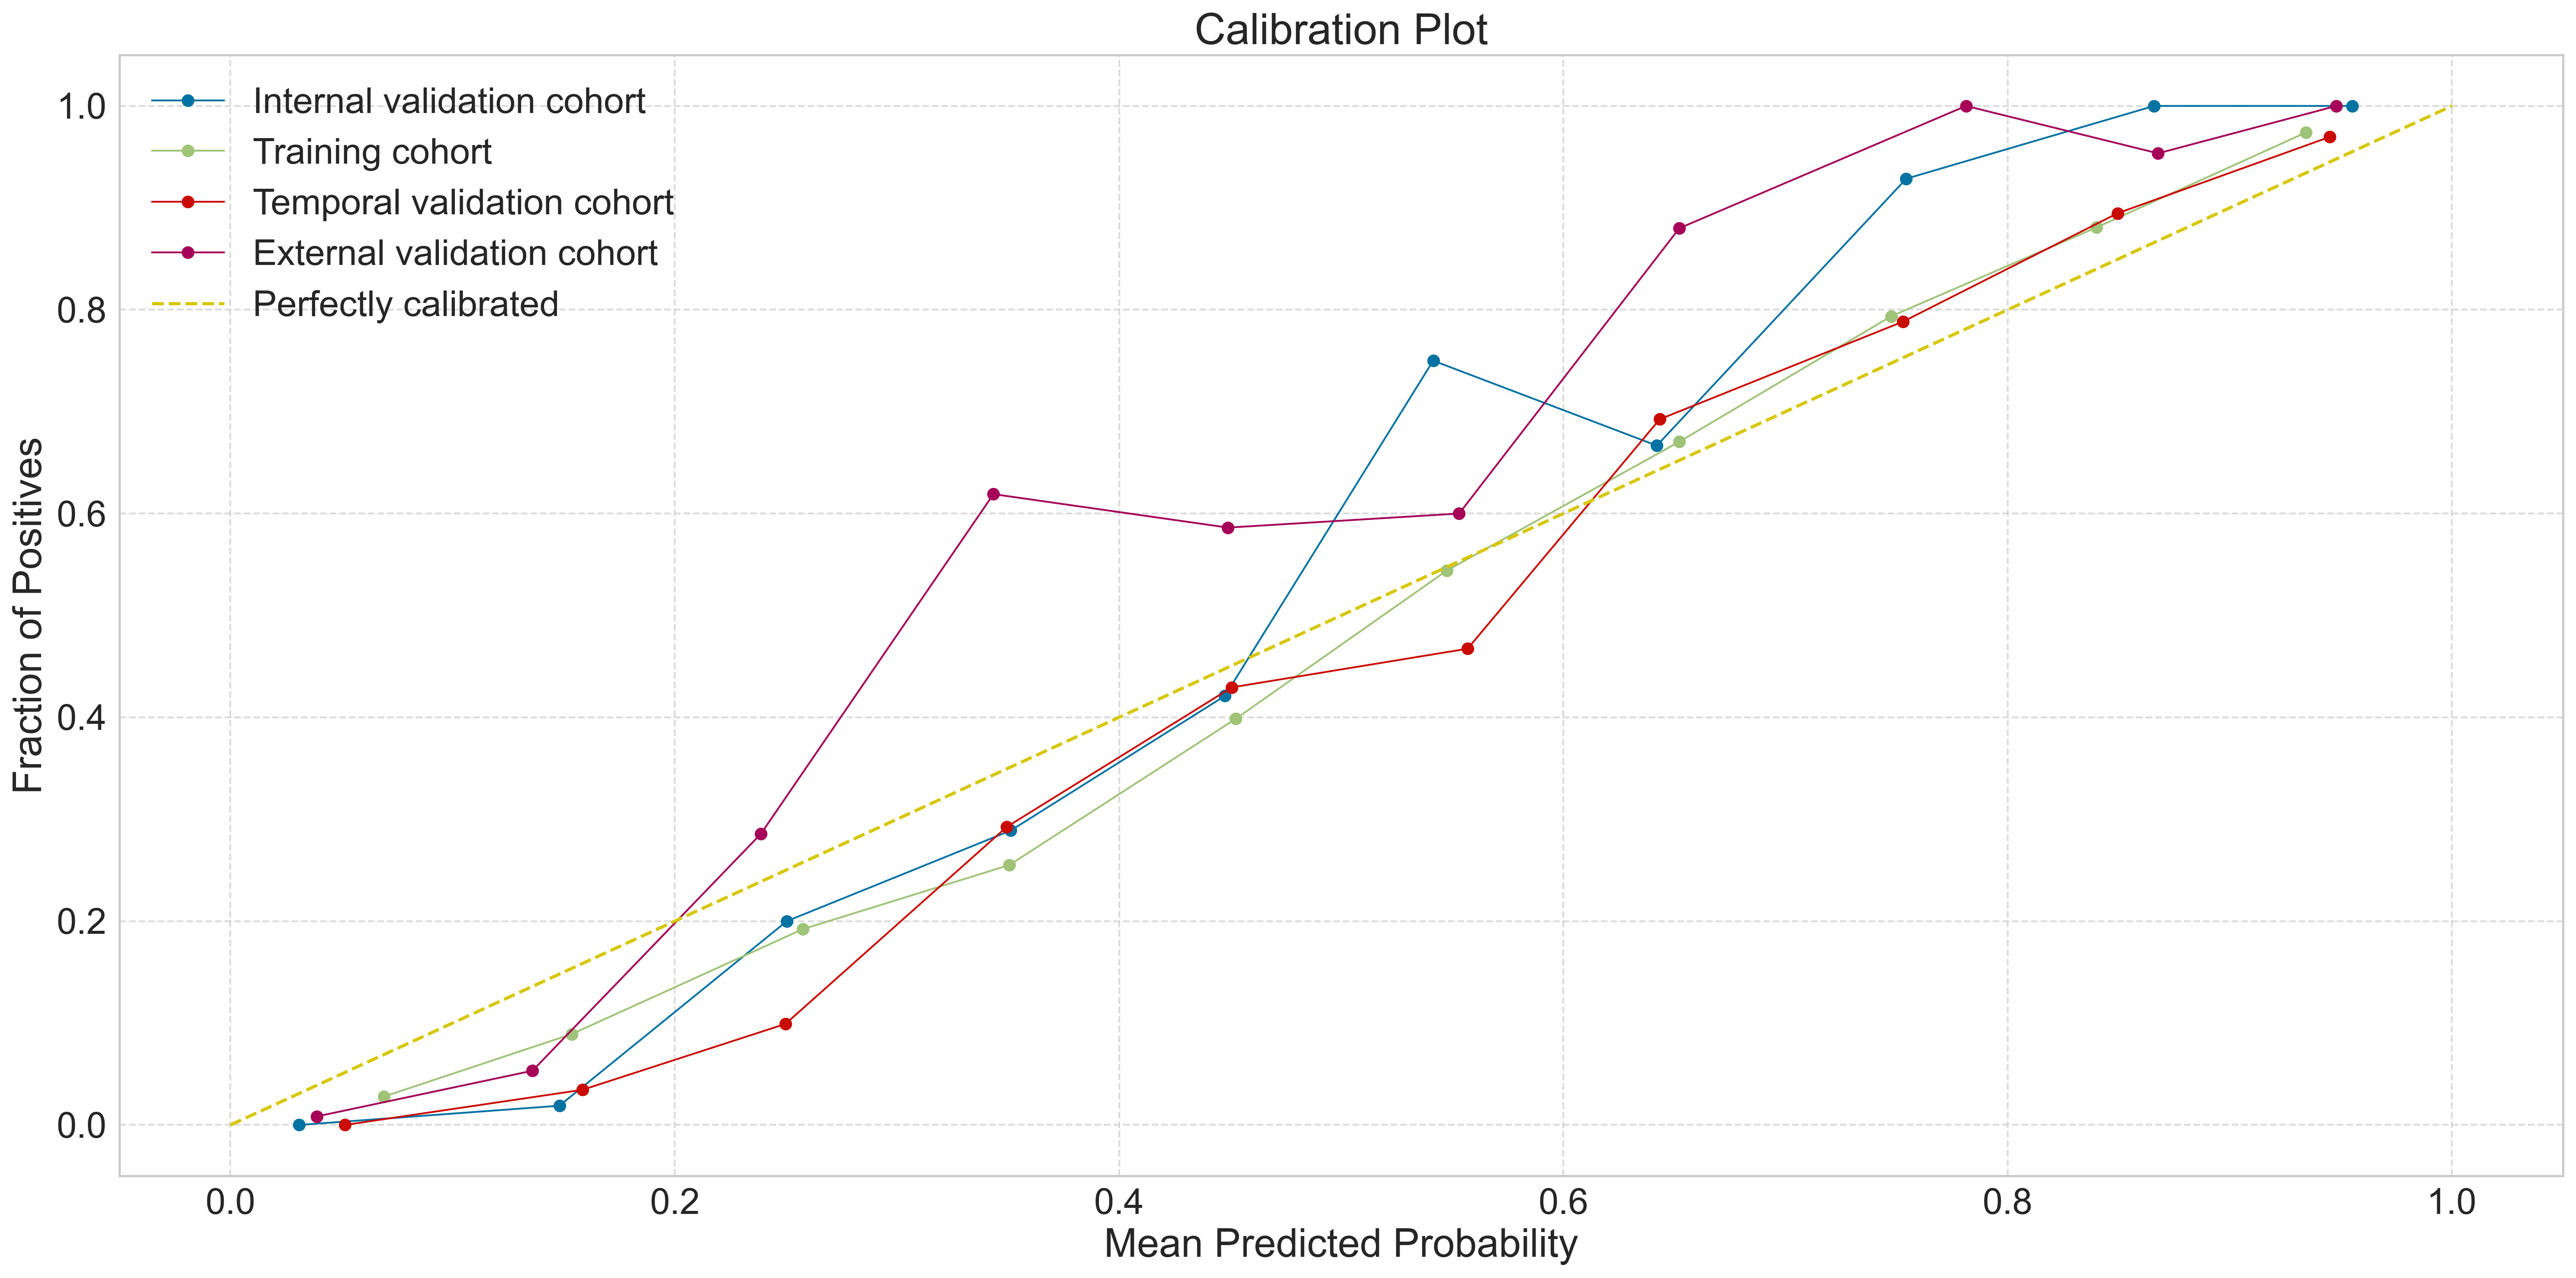

In [71]:
# Calibrate and predict for each dataset
probabilities_tr = calibrate_and_predict(final_model, train_data.iloc[:, 3:], train_data.iloc[:, 2])
probabilities = calibrate_and_predict(final_model, test_data.iloc[:, 3:], test_data.iloc[:, 2])
probabilities_tmp = calibrate_and_predict(final_model, tmp_data.iloc[:, 3:], tmp_data.iloc[:, 2])
probabilities_ex = calibrate_and_predict(final_model, ex_data.iloc[:, 3:], ex_data.iloc[:, 2])

# Calculate calibration curves
prob_true, prob_pred = calibration_curve(test_data.iloc[:, 2], probabilities, n_bins=10)
prob_true_tr, prob_pred_tr = calibration_curve(train_data.iloc[:, 2], probabilities_tr, n_bins=10)
prob_true_tmp, prob_pred_tmp = calibration_curve(tmp_data.iloc[:, 2], probabilities_tmp, n_bins=10)
prob_true_ex, prob_pred_ex = calibration_curve(ex_data.iloc[:, 2], probabilities_ex, n_bins=10)

# Plotting
fig = plt.figure(figsize=(20, 10))
fig.set_dpi(300.0)
ax = fig.add_subplot(1, 1, 1)
sns.set_style("whitegrid")

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Internal validation cohort')
plt.plot(prob_pred_tr, prob_true_tr, marker='o', linewidth=1, label='Training cohort')
plt.plot(prob_pred_tmp, prob_true_tmp, marker='o', linewidth=1, label='Temporal validation cohort')
plt.plot(prob_pred_ex, prob_true_ex, marker='o', linewidth=1, label='External validation cohort')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

plt.xlabel('Mean Predicted Probability', fontsize=22)
plt.ylabel('Fraction of Positives', fontsize=22)
plt.title('Calibration Plot', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
#plt.savefig('calibration_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Decision curve analysis

In [64]:
import numpy as np

In [65]:
def net_benefit(y_true, y_prob, threshold):
    true_positives = (y_true & (y_prob > threshold)).sum()
    false_positives = ((y_true == 0) & (y_prob > threshold)).sum()
    benefit = true_positives - false_positives * (0.519 * (threshold / (1 - threshold)))
    return benefit / len(y_true)

In [66]:
thresholds_l = np.linspace(0,1,1000)

In [82]:
probabilities_tr = calibrate_and_predict(final_model, train_data.iloc[:, 3:], train_data.iloc[:, 2])
probabilities = calibrate_and_predict(final_model, test_data.iloc[:, 3:], test_data.iloc[:, 2])
probabilities_tmp = calibrate_and_predict(final_model, tmp_data.iloc[:, 3:], tmp_data.iloc[:, 2])
probabilities_ex = calibrate_and_predict(final_model, ex_data.iloc[:, 3:], ex_data.iloc[:, 2])

5130

In [83]:
net_benefits = [net_benefit(train_data.iloc[:, 2], probabilities_tr, t) for t in thresholds_l]

In [84]:
treat_all = [train_data.iloc[:, 2].sum() / len(train_data) - t for t in thresholds_l]

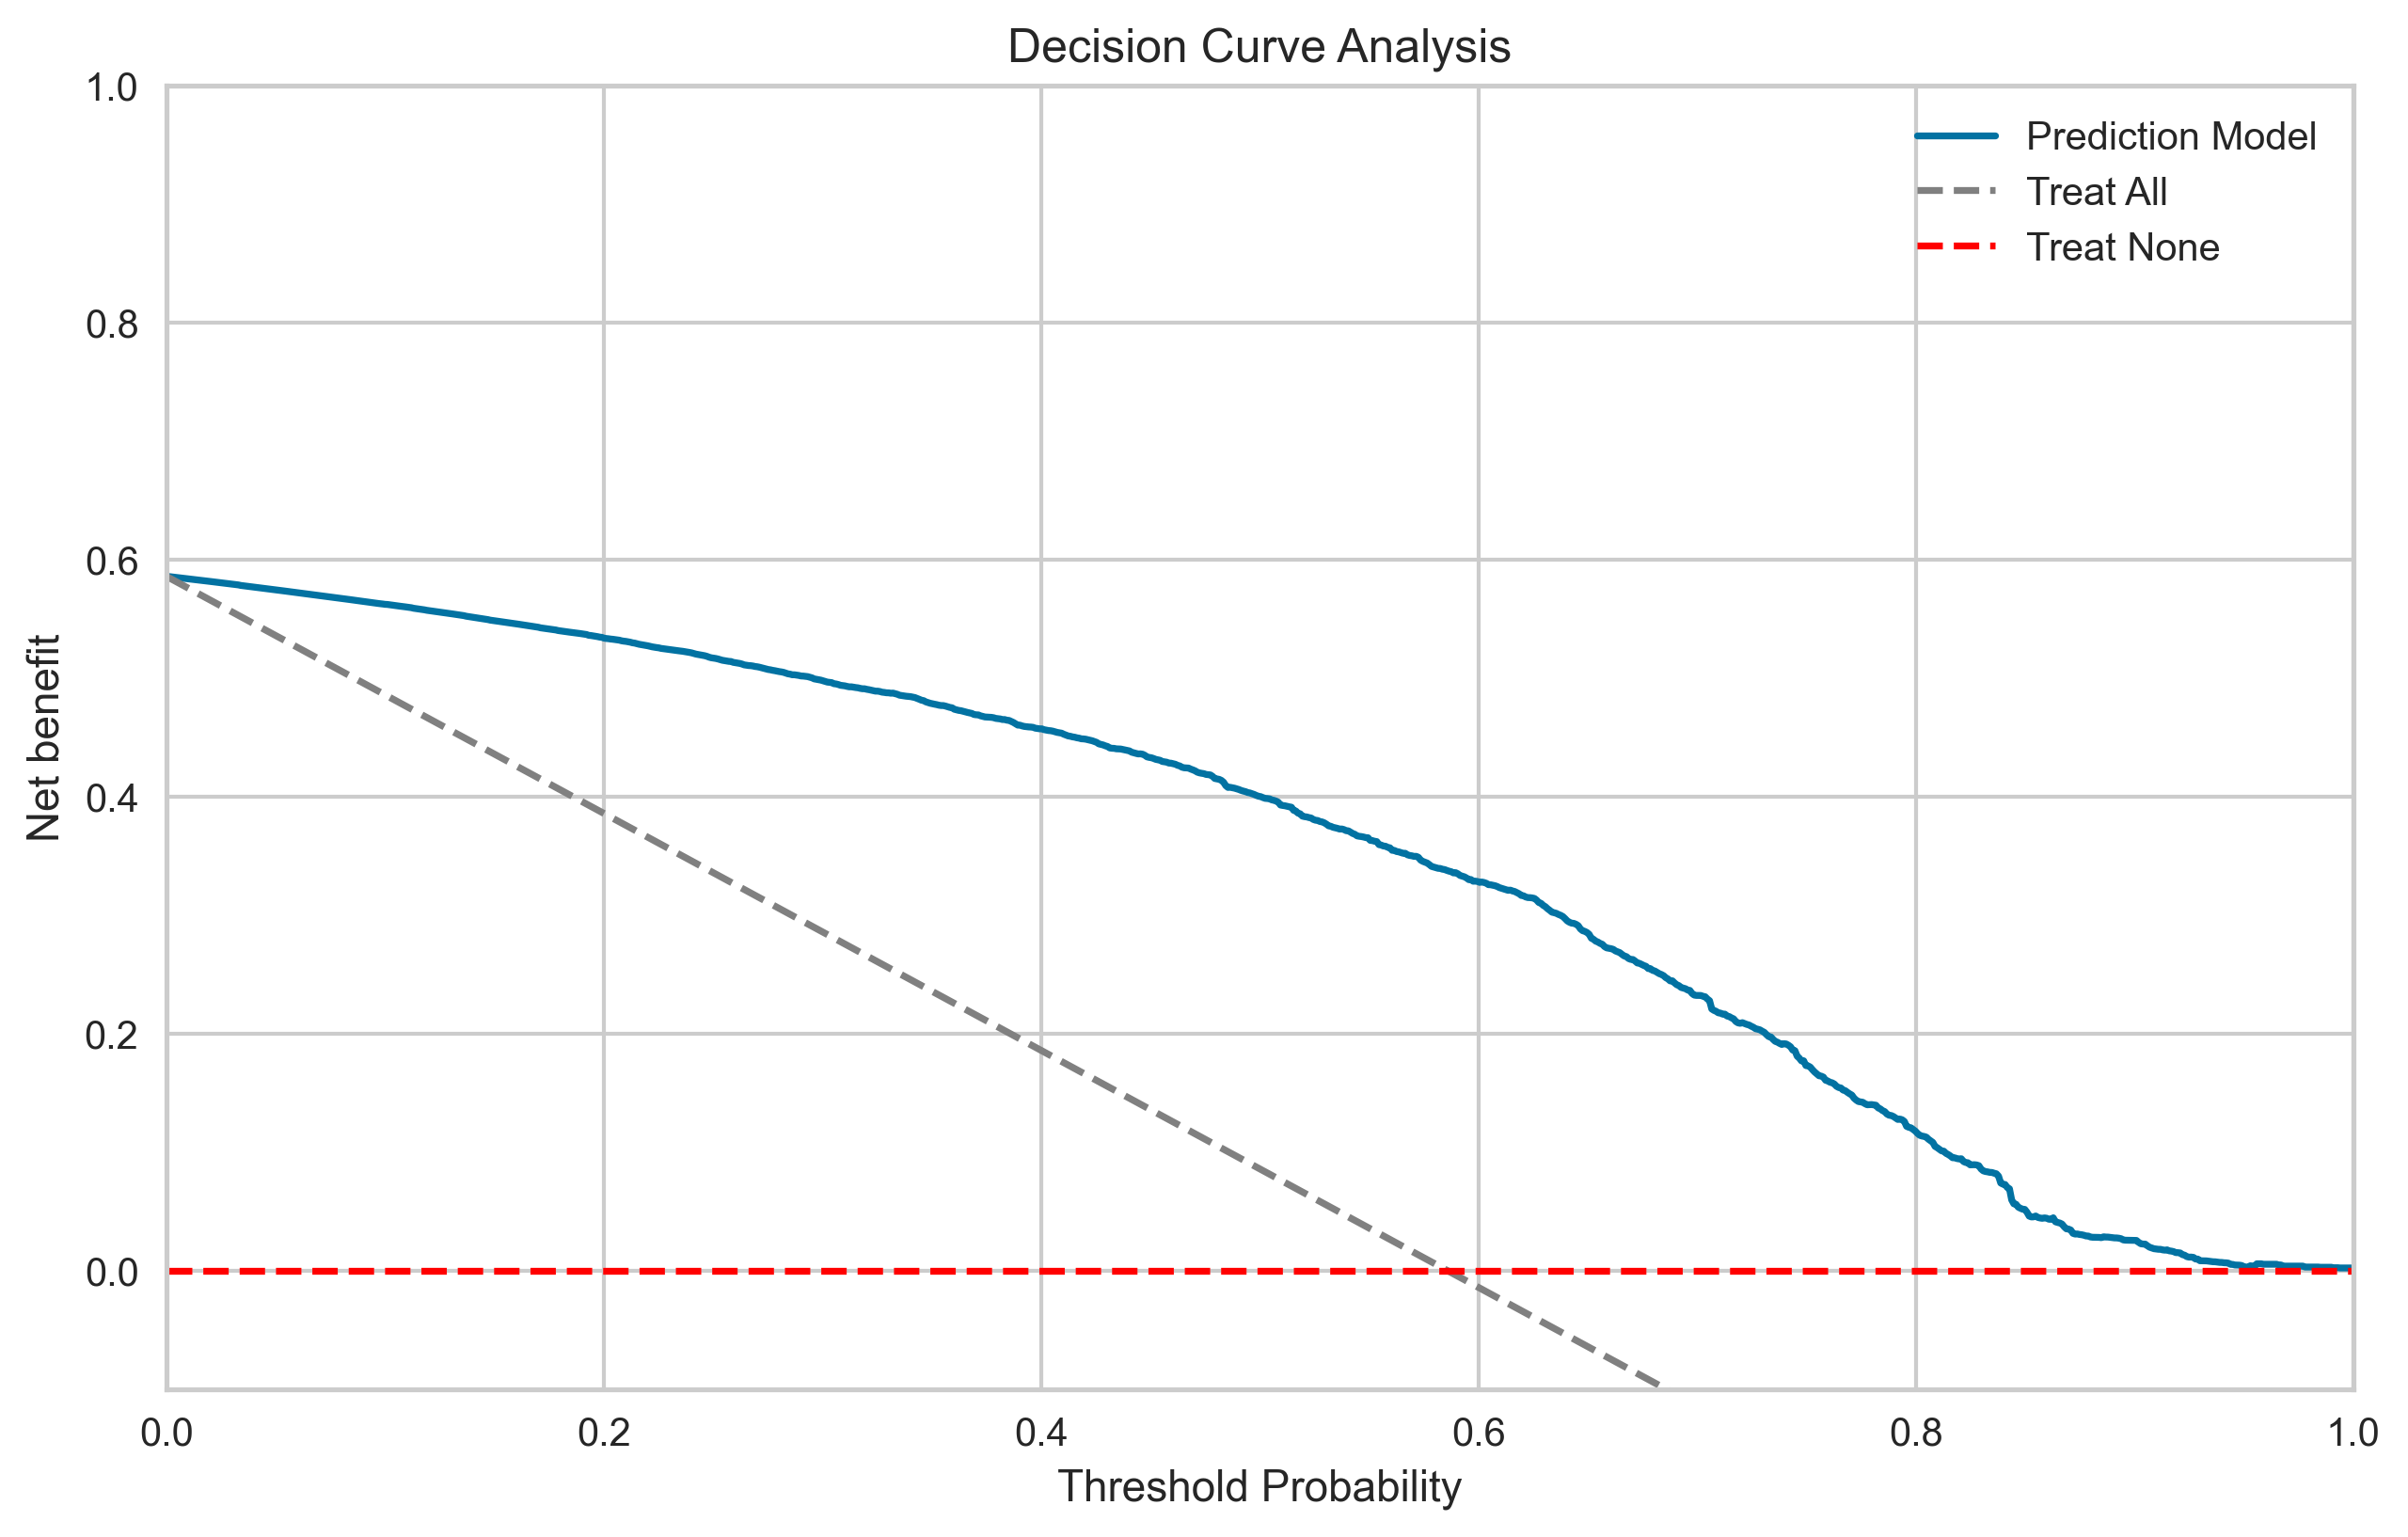

In [86]:
plt.figure(figsize=(10,6))
plt.plot(thresholds_l, net_benefits, label='Prediction Model')
plt.plot(thresholds_l, treat_all, linestyle='--', color='grey', label='Treat All')
plt.plot(thresholds_l, [0]*len(thresholds_l), linestyle='--', color='red', label='Treat None')
plt.ylim(-0.1, 1)
plt.xlim(0, 1)
plt.xlabel('Threshold Probability')
plt.ylabel('Net benefit')
plt.title('Decision Curve Analysis')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()


In [87]:
print(final_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=3, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=2, oob_score=False,
                       random_state=8709, verbose=0, warm_start=False)


In [88]:
params = final_model.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 5, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': 2, 'oob_score': False, 'random_state': 8709, 'verbose': 0, 'warm_start': False}


In [101]:
print("트리 개수:", final_model.n_estimators)
print("최대 깊이:", final_model.max_depth)
print("최소 샘플 분할:", final_model.min_samples_split)
print("최소 샘플 리프:", final_model.min_samples_leaf)
print()

트리 개수: 50
최대 깊이: 3
최소 샘플 분할: 9
최소 샘플 리프: 5
log2


In [90]:
from pycaret.classification import pull
model_details = pull(final_model)
print(model_details)

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6462  0.7347  0.7943  0.6043  0.6864  0.2974  0.3122
1       0.6825  0.6996  0.7642  0.7705  0.7673  0.2674  0.2674
2       0.6212  0.6832  0.6368  0.6959  0.6650  0.2311  0.2323
3       0.7465  0.8104  0.9163  0.7296  0.8124  0.4369  0.4646
4       0.6462  0.7027  0.7535  0.6864  0.7184  0.2455  0.2474
5       0.6630  0.7019  0.6436  0.7263  0.6824  0.3261  0.3288
6       0.6657  0.7586  0.7653  0.6996  0.7309  0.2921  0.2942
7       0.7465  0.7943  0.8986  0.7386  0.8108  0.4377  0.4575
8       0.6769  0.7357  0.7619  0.7080  0.7339  0.3240  0.3254
9       0.6462  0.7052  0.8434  0.6350  0.7245  0.2568  0.2777
Mean    0.6741  0.7326  0.7778  0.6994  0.7332  0.3115  0.3208
Std     0.0399  0.0408  0.0880  0.0465  0.0481  0.0695  0.0763


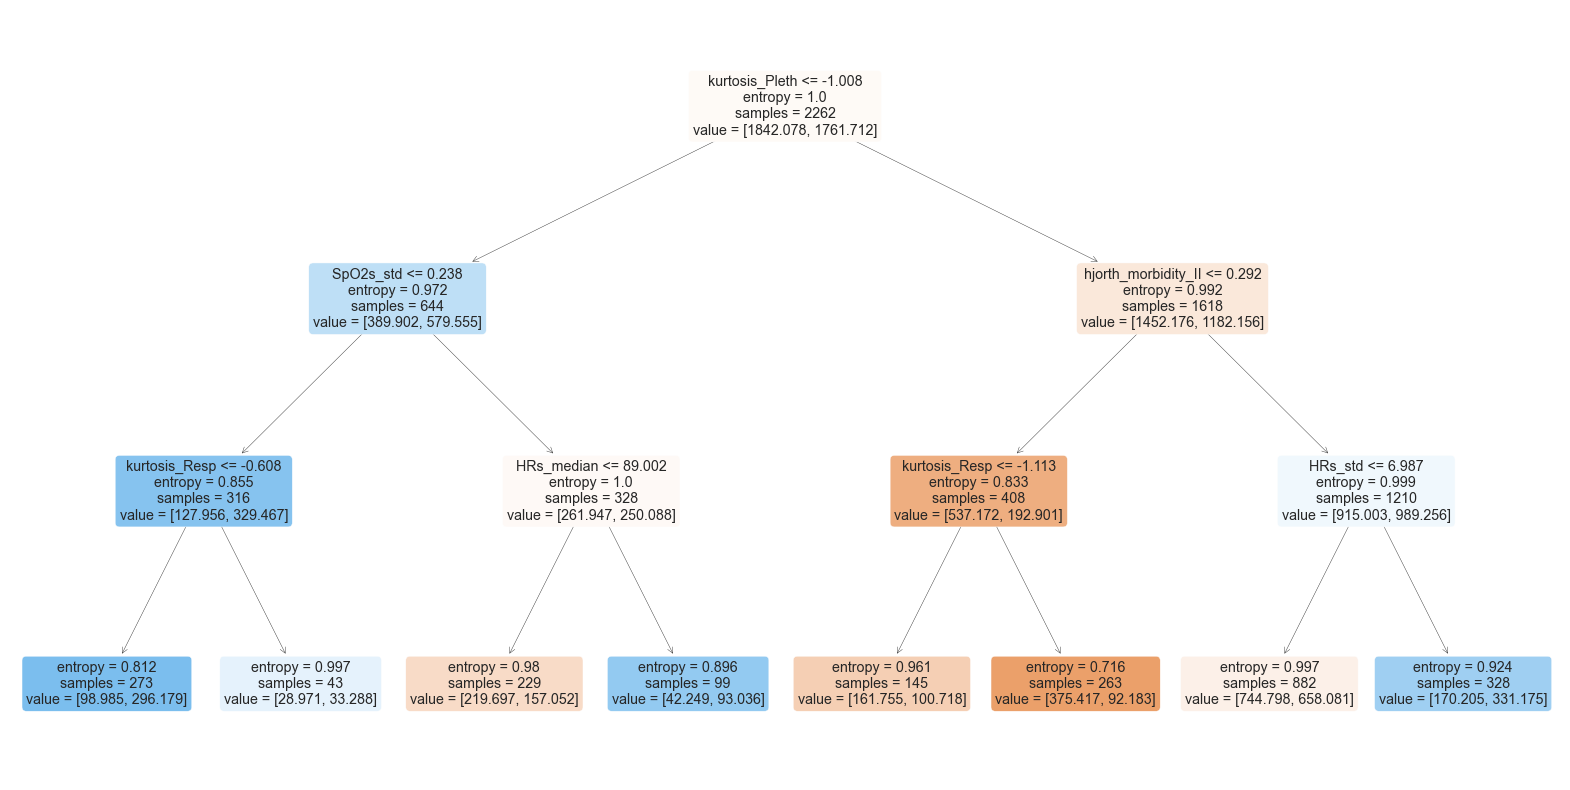

In [98]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Random Forest의 첫 번째 트리 시각화
plt.figure(figsize=(20,10))
plot_tree(final_model.estimators_[2], feature_names=train_data.iloc[:,3:].columns, filled=True, rounded=True)
plt.show()

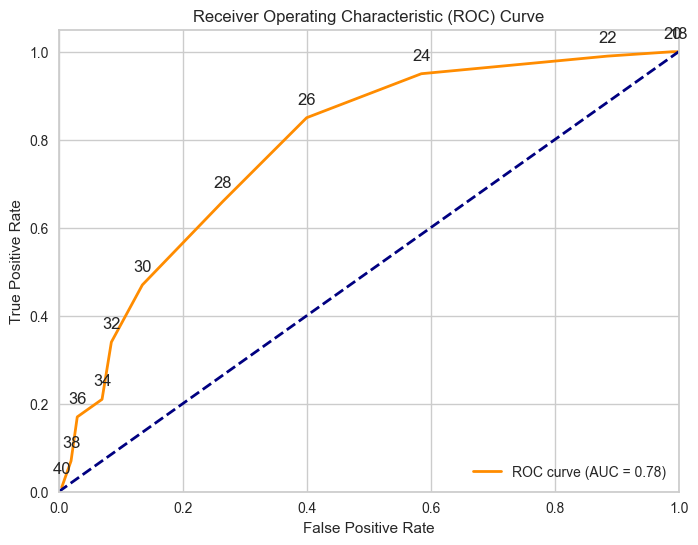

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Extract sensitivity and specificity from the table
sensitivity = [1.0, 1.0, 0.99, 0.95, 0.85, 0.66, 0.47, 0.34, 0.21, 0.17, 0.07, 0.01]
specificity = [0.0, 0.01, 0.115, 0.415, 0.60, 0.735, 0.865, 0.915, 0.93, 0.97, 0.98, 0.995]

# Calculate false positive rate (1 - specificity)
fpr = [1 - spec for spec in specificity]

# Reverse the order to get the correct ROC curve
tpr = sensitivity[::-1]
fpr = fpr[::-1]

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Create the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add BMI cut-off points
bmi_cutoffs = [40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18]
for i, bmi in enumerate(bmi_cutoffs):
    plt.annotate(f'{bmi}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()